<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>SECTION 3 - DATA ANALYSIS AND MODELING</strong></p> 

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>1. LIBRARIES</strong></p> 

In [1]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import cv2
import math
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skimage.measure import shannon_entropy
from PIL import Image
from skimage.measure import shannon_entropy
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import random
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\soner.kar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>2. CONFIGURATION</strong></p> 

In [2]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Label (image class) list
labels = [
    "nature", "animal", "human", "cat", "dog", "sky", "bird", 
    "car", "indoor", "food", "architecture", "sunset", "sea", 
    "landscape", "street", "flower", "abstract", "sports", "technology",
     "forest", "city", "lake", "ocean", "vehicle", "tree", "beach"
]

# Folder of downloaded images
from config import project_root
downloaded_images = f"{project_root}/downloaded_images/"

# Result of classification
results = []

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 <a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>3. CLASSIFICATION</strong></p> 

Classifying...: 100%|██████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.22it/s]



Images have been successfully classified and saved to 'C:\Users\soner.kar\Desktop\My Projects\SözlükLens/7_dataset_classified.xlsx/images/df_classified'


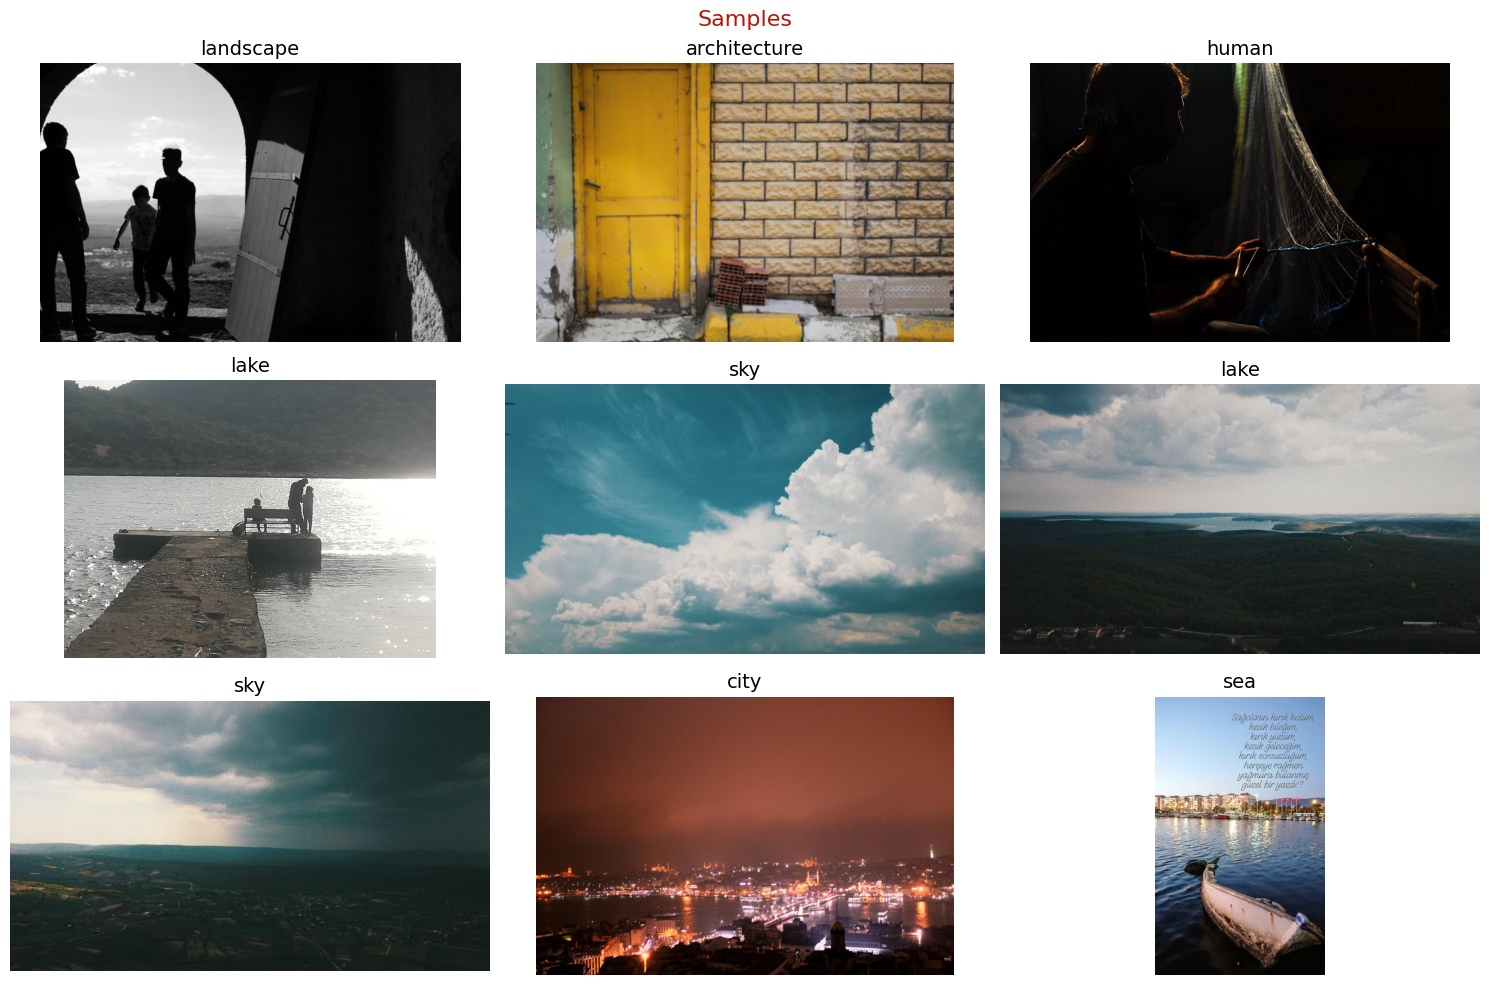

In [3]:
# Sort images by their number
image_files = sorted(
    [f for f in os.listdir(downloaded_images) if f.endswith(".jpg")],
    key=lambda x: int(x.split("_")[1].split(".")[0])
)

for image_name in tqdm(image_files, desc="Classifying..."):
    image_path = os.path.join(downloaded_images, image_name)
    
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Hata ({image_name}): {e}")
        continue

    # Process image + text prompts
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)

    # Measure similarity between image and text vectors
    logits_per_image = outputs.logits_per_image  # shape: [1, num_labels]
    probs = logits_per_image.softmax(dim=1)       # prob.

    # Select the label with the highest probability
    pred_class = labels[probs.argmax().item()]
    results.append((image_name, pred_class))

# Save as a df
name_df_classes = "7_dataset_classified.xlsx"
path_df_classes = f"{project_root}/{name_df_classes}/"
df_classes = pd.DataFrame(results, columns=["img_name", "image_class"])
df_classes.to_excel(name_df_classes, index=False)

print(f"\nImages have been successfully classified and saved to '{path_df_classes}images/df_classified'")

# Show samples
sample_images = df_classes.tail(9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle('Samples', fontsize=16, color='#b51509')

for idx, (img_name, img_class) in enumerate(zip(sample_images["img_name"], sample_images["image_class"])):
    img_path = os.path.join(downloaded_images, img_name)
    image = Image.open(img_path).convert("RGB")
    
    axes[idx].imshow(image)
    axes[idx].set_title(img_class, fontsize=14)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>4. CREATE DF</strong></p> 

In [5]:
def alphanumeric_key(filename):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', filename)]

df_classes = pd.DataFrame(results, columns=["img_name", "image_class"])
df_sorted = df_classes.sort_values(by='img_name', key=lambda x: x.apply(alphanumeric_key))

df_sorted.to_excel("8_dataset_clip.xlsx", index=False)

In [6]:
# Read the main df
df = pd.read_excel(r"D:\My Projects\Project Eksi Sozluk - vX5 - Sıfırdan\6_dataset_final.xlsx")
from config import final_file_path
df = pd.read_excel(final_file_path)

# Load CLIP model classification results
df_classes = pd.read_excel("8_dataset_clip.xlsx")

# To extract 'img_index' value: img_12345.jpg → 12345
df_classes['img_index'] = df_classes['img_name'].str.extract(r'(\d+)').astype(int)

# Merge
df_merged = pd.merge(df, df_classes[['img_index', 'image_class']], on='img_index', how='left')

# Save the new df
df_merged.to_excel("9_dataset_final_merged.xlsx", index=False)

print("Labels (image classes) added to the main dataframe. New column: 'image_class'")

Labels (image classes) added to the main dataframe. New column: 'image_class'


### Create a new column: 'path'

In [6]:
df = pd.read_excel("9_dataset_final_merged.xlsx")
project_root = fr"{downloaded_images}img_"
df['path'] = df['img_index'].apply(lambda x: f"{project_root}{x}.jpg")
print('example path:', df['path'][2])

example path: C:\Users\soner.kar\Desktop\My Projects\SözlükLens/downloaded_images/img_3.jpg


### Sample Images After Classification

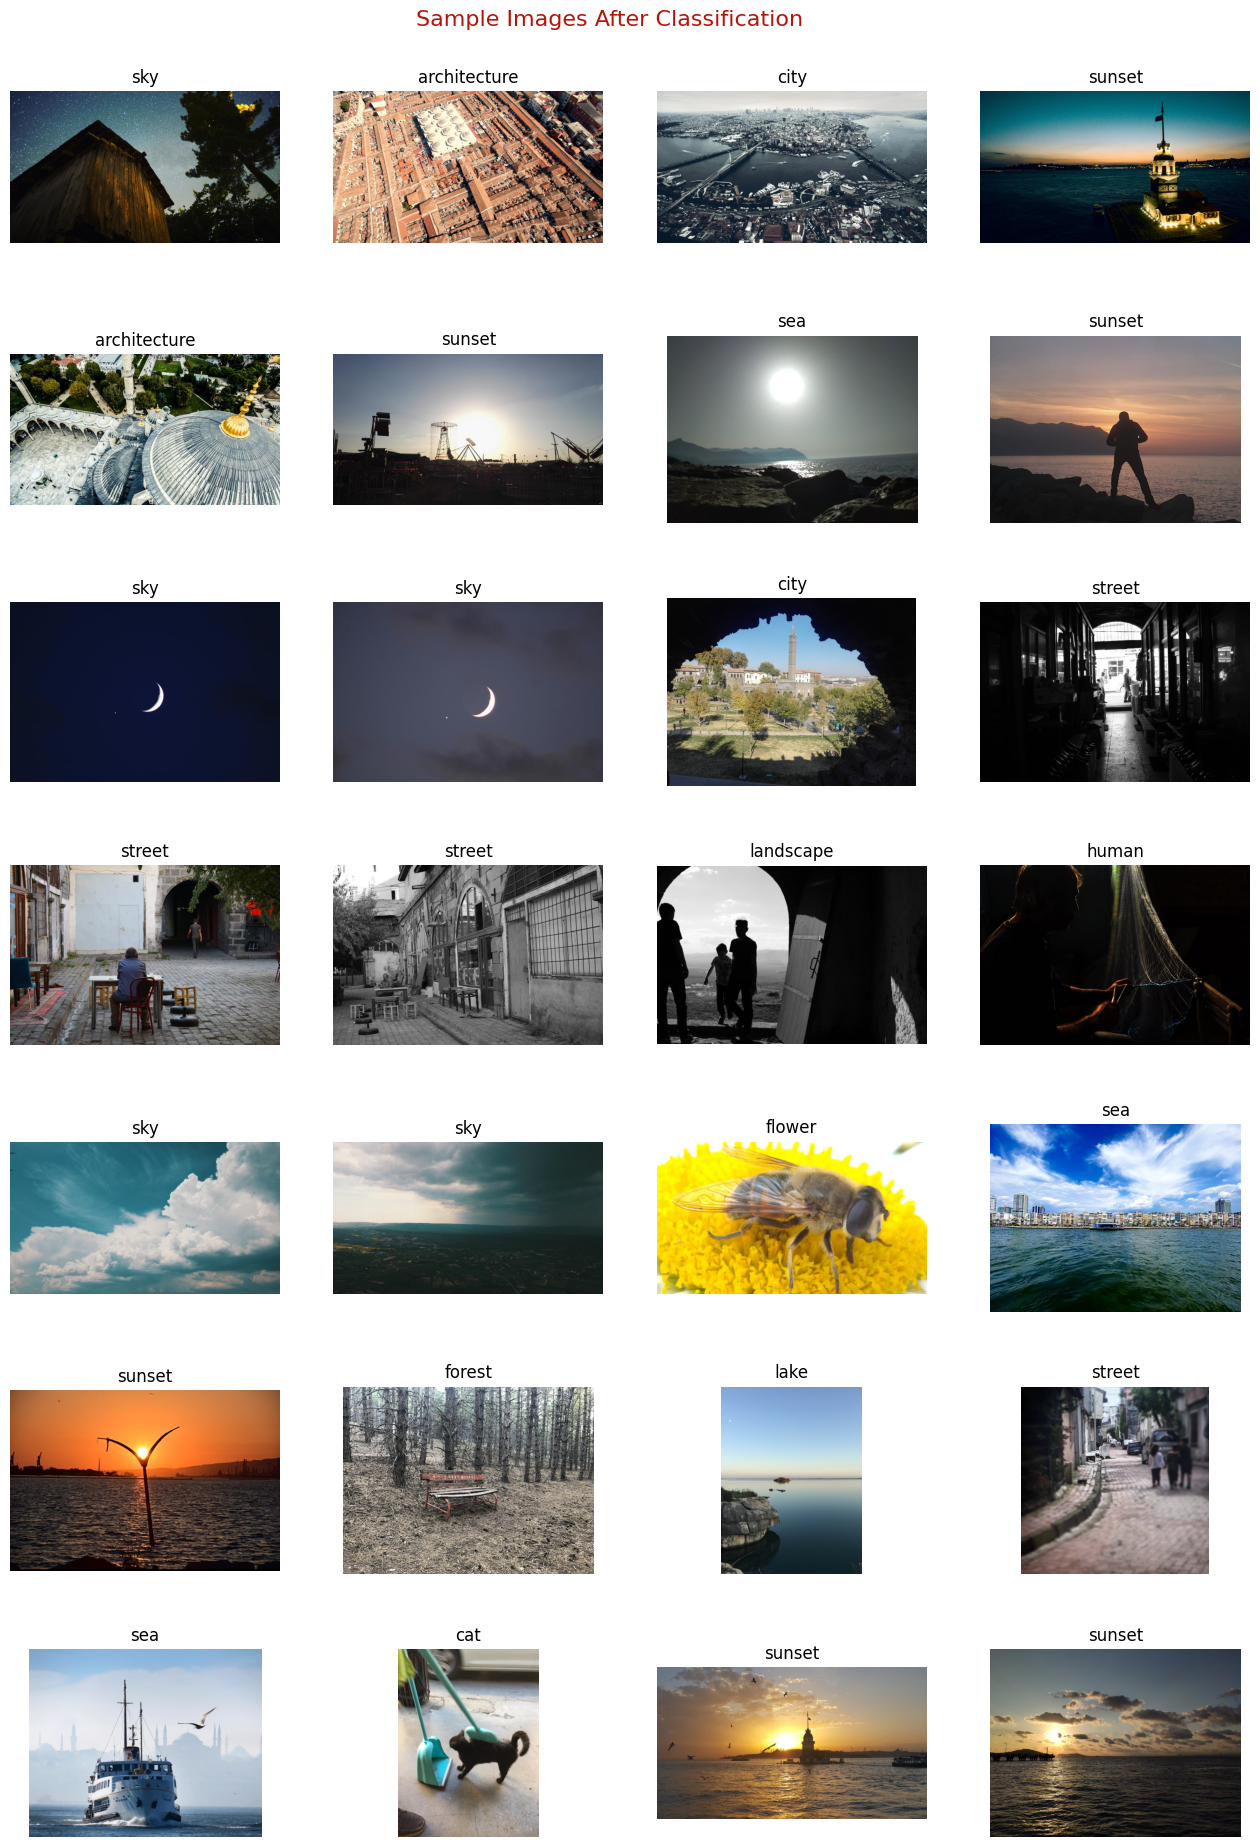

In [8]:
plt.figure(figsize=(16, 21))
plt.suptitle('Sample Images After Classification', color='#b51509', fontsize=16)
plt.subplots_adjust(top=0.95, hspace=0.4)

for i in range(28):
    img = Image.open(df['path'][2*i])
    plt.subplot(7,4,i+1)
    plt.title(df['image_class'][2*i])
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

### Change target column (image class) order

In [9]:
cols = list(df.columns)
cols.remove('image_class')
cols = ['image_class'] + cols
df = df[cols]
df.head(2)

image_class  img_index                                            img_url  \
0           sky          1  https://cdn.eksisozluk.com/2014/9/2/y/ydqeqxbz...   
1  architecture          2  https://cdn.eksisozluk.com/2014/9/2/j/jukc5bb4...   

   entry_favorites        entry_date   entry_edit_date  entry_id  \
0              102  02.09.2014 14:26  26.03.2021 00:00  45405875   
1              102  02.09.2014 14:26  26.03.2021 00:00  45405875   

                                       entry_content entry_author_name  \
0  pek aram yoktur fotoğraf ile ama şunları sever...           ciodeth   
1  pek aram yoktur fotoğraf ile ama şunları sever...           ciodeth   

   entry_author_id                                               path  
0           492579  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  
1           492579  C:\Users\soner.kar\Desktop\My Projects\SözlükL...

**The 'image class' column is at the top now.**

### Change column names

In [10]:
columns_old = []
for column in df.columns:
    columns_old.append(column)
    
df = df.rename(columns={"image_class": "class",
                        "img_index": "index",
                        "img_url": "url",
                        "entry_favorites": "likes",
                        "entry_date": "date",
                        "entry_edit_date": "edit_date",
                        "entry_id": "id",
                        "entry_content": "content",
                        "entry_author_name": "author_name",
                        "entry_author_id": "author_id"})

print('\n-Columns BEFORE/AFTER Renaming-')
for i, column in enumerate(df.columns):
    print(f'{i+1:<2} {columns_old[i]:<20} -> {column}')


-Columns BEFORE/AFTER Renaming-
1  image_class          -> class
2  img_index            -> index
3  img_url              -> url
4  entry_favorites      -> likes
5  entry_date           -> date
6  entry_edit_date      -> edit_date
7  entry_id             -> id
8  entry_content        -> content
9  entry_author_name    -> author_name
10 entry_author_id      -> author_id
11 path                 -> path


<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>5. EDA</strong></p>

In [11]:
df.tail().T

68284  \
class                                                   street   
index                                                    68285   
url          https://cdn.eksisozluk.com/2025/4/23/j/jffivgi...   
likes                                                        0   
date                                          23.04.2025 11:27   
edit_date                                                  NaN   
id                                                   174758095   
content      güzellik, düzenli olmak değil; doğallığın için...   
author_name                                            oflumst   
author_id                                              1675419   
path         C:\Users\soner.kar\Desktop\My Projects\SözlükL...   

                                                         68285  \
class                                                      cat   
index                                                    68286   
url          https://cdn.eksisozluk.com/2025/4/23/k/kmbujhr...   
likes                                                        0   
date                                          23.04.2025 11:27   
edit_date                                                  NaN   
id                                                   174758095   
content      güzellik, düzenli olmak değil; doğallığın için...   
author_name                                            oflumst   
author_id                                              1675419   
path         C:\Users\soner.kar\Desktop\My Projects\SözlükL...   

                                                         68286  \
class                                             architecture   
index                                                    68287   
url          https://cdn.eksisozluk.com/2025/4/23/p/prp0bk3...   
likes                                                        0   
date                                          23.04.2025 11:27   
edit_date                                                  NaN   
id                                                   174758095   
content      güzellik, düzenli olmak değil; doğallığın için...   
author_name                                            oflumst   
author_id                                              1675419   
path         C:\Users\soner.kar\Desktop\My Projects\SözlükL...   

                                                         68287  \
class                                                landscape   
index                                                    68288   
url          https://cdn.eksisozluk.com/2025/4/23/t/tvilfek...   
likes                                                        0   
date                                          23.04.2025 11:27   
edit_date                                                  NaN   
id                                                   174758095   
content      güzellik, düzenli olmak değil; doğallığın için...   
author_name                                            oflumst   
author_id                                              1675419   
path         C:\Users\soner.kar\Desktop\My Projects\SözlükL...   

                                                         68288  
class                                                   indoor  
index                                                    68289  
url          https://cdn.eksisozluk.com/2025/4/23/p/psbd137...  
likes                                                        0  
date                                          23.04.2025 11:27  
edit_date                                                  NaN  
id                                                   174758095  
content      güzellik, düzenli olmak değil; doğallığın için...  
author_name                                            oflumst  
author_id                                              1675419  
path         C:\Users\soner.kar\Desktop\My Projects\SözlükL...

### **Shape and info**

In [12]:
df.shape

(68289, 11)

**Dataset consists of 68289 rows and 11 columns.**

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68289 entries, 0 to 68288
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        68289 non-null  object
 1   index        68289 non-null  int64 
 2   url          68289 non-null  object
 3   likes        68289 non-null  int64 
 4   date         68289 non-null  object
 5   edit_date    2390 non-null   object
 6   id           68289 non-null  int64 
 7   content      68288 non-null  object
 8   author_name  68289 non-null  object
 9   author_id    68289 non-null  int64 
 10  path         68289 non-null  object
dtypes: int64(4), object(7)
memory usage: 5.7+ MB


**2390 of the entries have been edited.**

### Check null values

In [14]:
df.isnull().sum()

class              0
index              0
url                0
likes              0
date               0
edit_date      65899
id                 0
content            1
author_name        0
author_id          0
path               0
dtype: int64

**edit_date → 65899 entries have not been edited. Therefore, they are null. This is not a problem.**

**content   → There is only one entry with empty content. This row will be dropped.**

### Drop the row with empty content

In [15]:
df.dropna(subset=['content'], inplace=True)
df.isnull().sum()

class              0
index              0
url                0
likes              0
date               0
edit_date      65898
id                 0
content            0
author_name        0
author_id          0
path               0
dtype: int64

**The mentioned row has been dropped.**

### Create new columns: 'day, month, year, hour, minute'

In [16]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df.head(3)

class  index                                                url  \
0           sky      1  https://cdn.eksisozluk.com/2014/9/2/y/ydqeqxbz...   
1  architecture      2  https://cdn.eksisozluk.com/2014/9/2/j/jukc5bb4...   
2  architecture      3  https://cdn.eksisozluk.com/2014/9/2/g/grh1enp8...   

   likes                date         edit_date        id  \
0    102 2014-09-02 14:26:00  26.03.2021 00:00  45405875   
1    102 2014-09-02 14:26:00  26.03.2021 00:00  45405875   
2    102 2014-09-02 14:26:00  26.03.2021 00:00  45405875   

                                             content author_name  author_id  \
0  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   
1  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   
2  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   

                                                path  day  month  year  hour  \
0  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   
1  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   
2  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   

   minute  
0      26  
1      26  
2      26

### Create a new column: 'content_length'

In [17]:
df['content_length'] = df['content'].str.len()
df['content_length'].head()

0    156
1    156
2    156
3    156
4    156
Name: content_length, dtype: int64

# Create a new column: 'author_entry_count'

In [61]:
counts = Counter(list(df['author_name'])) # Counter comes from collections
author_content_list = []
df['author_entry_count'] = None

for i,name in enumerate(df['author_name']):
    df['author_entry_count'][i] = counts[name]

# convert column to numeric
df['author_entry_count'][len(df)] = counts[df['author_name'][len(df)]] #####
df['author_entry_count'] = pd.to_numeric(df['author_entry_count'], errors='coerce')
df.tail()

class_encoded         class  index  \
68284             21        street  68285   
68285              6           cat  68286   
68286              2  architecture  68287   
68287             15     landscape  68288   
68288             13        indoor  68289   

                                                     url  likes  \
68284  https://cdn.eksisozluk.com/2025/4/23/j/jffivgi...      0   
68285  https://cdn.eksisozluk.com/2025/4/23/k/kmbujhr...      0   
68286  https://cdn.eksisozluk.com/2025/4/23/p/prp0bk3...      0   
68287  https://cdn.eksisozluk.com/2025/4/23/t/tvilfek...      0   
68288  https://cdn.eksisozluk.com/2025/4/23/p/psbd137...      0   

                     date edit_date  content_length  author_entry_count  \
68284 2025-04-23 11:27:00       NaN             124                   7   
68285 2025-04-23 11:27:00       NaN             124                   7   
68286 2025-04-23 11:27:00       NaN             124                   7   
68287 2025-04-23 11:27:00       NaN             124                   7   
68288 2025-04-23 11:27:00       NaN             124                   7   

       is_edited  ...                                            content  \
68284          0  ...  güzellik, düzenli olmak değil; doğallığın için...   
68285          0  ...  güzellik, düzenli olmak değil; doğallığın için...   
68286          0  ...  güzellik, düzenli olmak değil; doğallığın için...   
68287          0  ...  güzellik, düzenli olmak değil; doğallığın için...   
68288          0  ...  güzellik, düzenli olmak değil; doğallığın için...   

      author_name author_id  \
68284     oflumst   1675419   
68285     oflumst   1675419   
68286     oflumst   1675419   
68287     oflumst   1675419   
68288     oflumst   1675419   

                                                    path day  month  year  \
68284  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  23      4  2025   
68285  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  23      4  2025   
68286  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  23      4  2025   
68287  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  23      4  2025   
68288  C:\Users\soner.kar\Desktop\My Projects\SözlükL...  23      4  2025   

       hour  minute  image_count_per_entry  
68284    11      27                      6  
68285    11      27                      6  
68286    11      27                      6  
68287    11      27                      6  
68288    11      27                      6  

[5 rows x 21 columns]

In [19]:
df.describe().T

count                           mean  \
index               68288.0                    34145.18214   
likes               68288.0                       3.961941   
date                  68288  2023-03-01 15:05:20.817420544   
id                  68288.0               148094949.246075   
author_id           68288.0                 1952542.056818   
day                 68288.0                      15.738475   
month               68288.0                       6.409398   
year                68288.0                    2022.672124   
hour                68288.0                      12.931804   
minute              68288.0                      28.831903   
content_length      68288.0                      93.295747   
author_entry_count  68287.0                      77.351692   

                                    min                  25%  \
index                               1.0             17072.75   
likes                               0.0                  1.0   
date                2014-09-02 14:26:00  2022-01-18 02:14:30   
id                           45405875.0          132469358.0   
author_id                        7160.0            1560090.0   
day                                 1.0                  8.0   
month                               1.0                  3.0   
year                             2014.0               2022.0   
hour                                0.0                  4.0   
minute                              0.0                 14.0   
content_length                      2.0                 18.0   
author_entry_count                  1.0                  6.0   

                                    50%                  75%  \
index                           34145.5             51217.25   
likes                               3.0                  5.0   
date                2023-03-16 11:48:00  2024-04-28 02:35:00   
id                          150382130.0          163889748.0   
author_id                     1931380.0            2459593.0   
day                                16.0                 23.0   
month                               6.0                 10.0   
year                             2023.0               2024.0   
hour                               15.0                 20.0   
minute                             29.0                 44.0   
content_length                     38.0                 69.0   
author_entry_count                 22.0                 68.0   

                                    max              std  
index                           68289.0     19713.567485  
likes                             327.0         7.096456  
date                2025-04-23 11:27:00              NaN  
id                          174758095.0  17448042.134947  
author_id                     3504212.0    673337.432332  
day                                31.0         8.780846  
month                              12.0         3.434684  
year                             2025.0         1.325003  
hour                               23.0         8.133125  
minute                             59.0        17.451891  
content_length                  12816.0       601.066494  
author_entry_count                913.0       150.579238

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">1. Correlations

**In order to view correlations, text columns that can be transformed need to be converted to numeric. Therefore, let's convert the target column 'Class' to numeric.**

In [20]:
# encode
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])
# change target columng order 
cols = df.columns.tolist()
new_cols = [cols[-1]] + cols[:-1]
df = df[new_cols]
df.head(3)

class_encoded         class  index  \
0             19           sky      1   
1              2  architecture      2   
2              2  architecture      3   

                                                 url  likes  \
0  https://cdn.eksisozluk.com/2014/9/2/y/ydqeqxbz...    102   
1  https://cdn.eksisozluk.com/2014/9/2/j/jukc5bb4...    102   
2  https://cdn.eksisozluk.com/2014/9/2/g/grh1enp8...    102   

                 date         edit_date        id  \
0 2014-09-02 14:26:00  26.03.2021 00:00  45405875   
1 2014-09-02 14:26:00  26.03.2021 00:00  45405875   
2 2014-09-02 14:26:00  26.03.2021 00:00  45405875   

                                             content author_name  author_id  \
0  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   
1  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   
2  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth     492579   

                                                path  day  month  year  hour  \
0  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   
1  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   
2  C:\Users\soner.kar\Desktop\My Projects\SözlükL...    2      9  2014    14   

   minute  content_length  author_entry_count  
0      26             156                 9.0  
1      26             156                 9.0  
2      26             156                 9.0

# Image classes

In [21]:
print('Image Classes\n')
for i in range(len(le.classes_)):
    print(f"{i+1}: {le.classes_[i]}")

Image Classes

1: abstract
2: animal
3: architecture
4: beach
5: bird
6: car
7: cat
8: city
9: dog
10: flower
11: food
12: forest
13: human
14: indoor
15: lake
16: landscape
17: nature
18: ocean
19: sea
20: sky
21: sports
22: street
23: sunset
24: technology
25: tree
26: vehicle


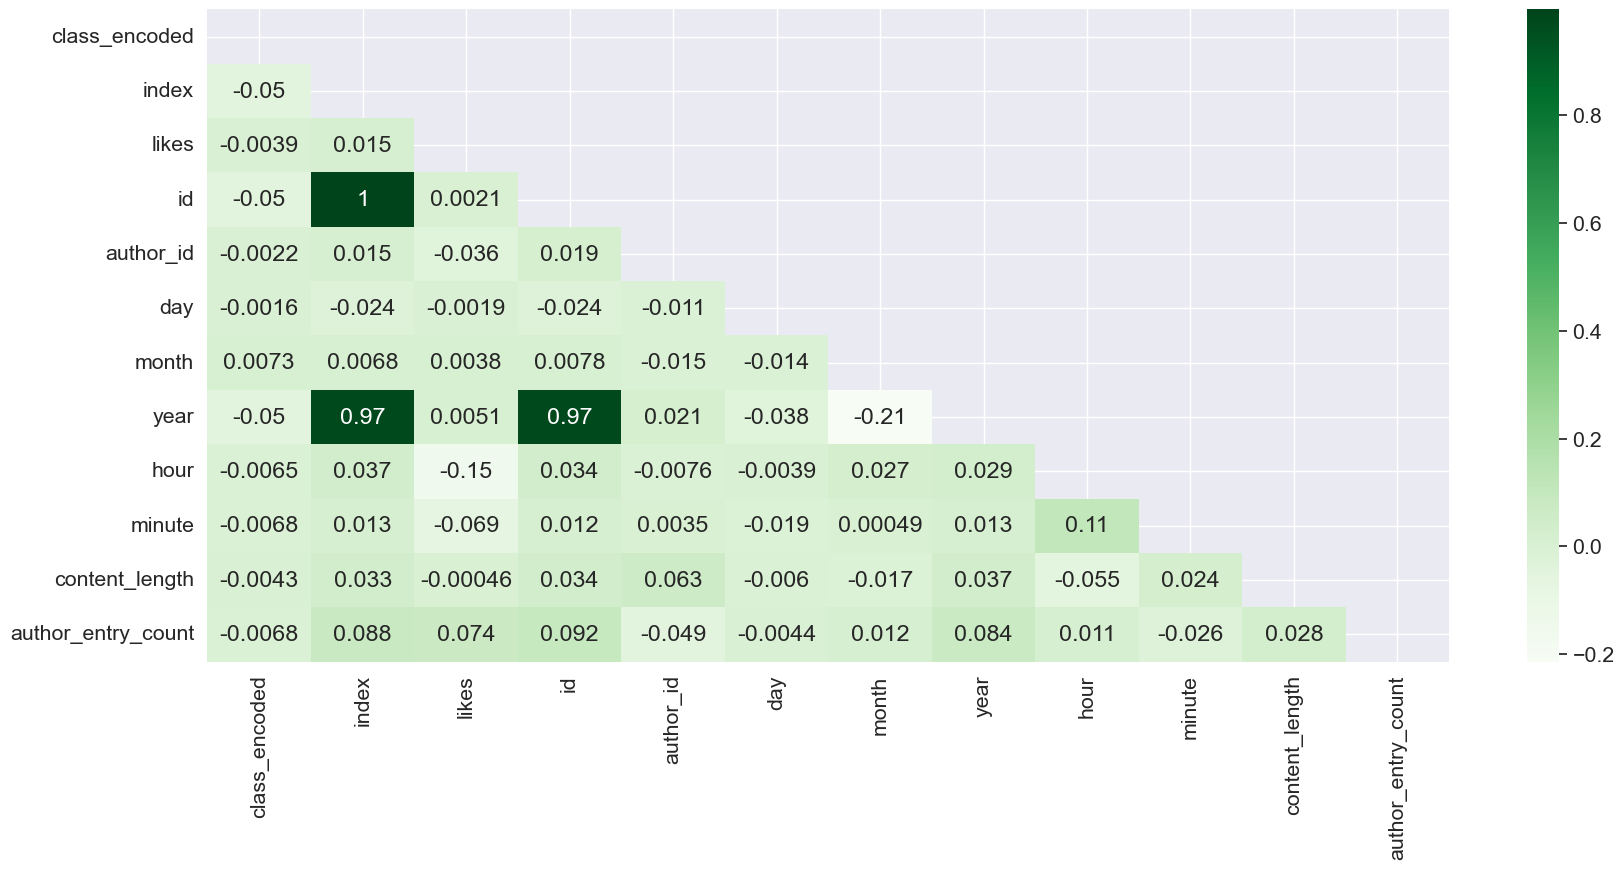

In [22]:
df_numeric = df.select_dtypes(include=['number'])
cor = df_numeric.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.set(font_scale=1.4)
plt.figure(figsize=(18,9))
sns.heatmap(cor, annot=True, mask=mask, cmap='Greens')
plt.tight_layout()
plt.show()

# Top 10 positive/negative correlations

In [23]:
print('Top 10 positive correlations:\n')
for i in range(11):
    if i!=0:
        print(f"{i}) {cor.unstack().sort_values(ascending=False).drop_duplicates()[i]:.2f} => {cor.unstack().sort_values(ascending=False).drop_duplicates().index[i]}")

Top 10 positive correlations:

1) 1.00 => ('index', 'id')
2) 0.97 => ('year', 'id')
3) 0.97 => ('index', 'year')
4) 0.11 => ('minute', 'hour')
5) 0.09 => ('author_entry_count', 'id')
6) 0.09 => ('author_entry_count', 'index')
7) 0.08 => ('year', 'author_entry_count')
8) 0.07 => ('likes', 'author_entry_count')
9) 0.06 => ('author_id', 'content_length')
10) 0.04 => ('content_length', 'year')


In [24]:
print('Top 10 negative correlations:\n')
for i in range(11):
    if i!=0:
        print(f"{i}) {cor.unstack().sort_values(ascending=True).drop_duplicates()[i-1]:.2f} => {cor.unstack().sort_values(ascending=True).drop_duplicates().index[i-1]}")

Top 10 negative correlations:

1) -0.21 => ('year', 'month')
2) -0.15 => ('likes', 'hour')
3) -0.07 => ('minute', 'likes')
4) -0.06 => ('hour', 'content_length')
5) -0.05 => ('index', 'class_encoded')
6) -0.05 => ('id', 'class_encoded')
7) -0.05 => ('class_encoded', 'year')
8) -0.05 => ('author_entry_count', 'author_id')
9) -0.04 => ('day', 'year')
10) -0.04 => ('likes', 'author_id')


In [25]:
cor['likes'].sort_values(ascending=False)

likes                 1.000000
author_entry_count    0.073717
index                 0.015434
year                  0.005052
month                 0.003804
id                    0.002124
content_length       -0.000456
day                  -0.001858
class_encoded        -0.003873
author_id            -0.035866
minute               -0.068878
hour                 -0.154249
Name: likes, dtype: float64

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">2. Distribution Plots

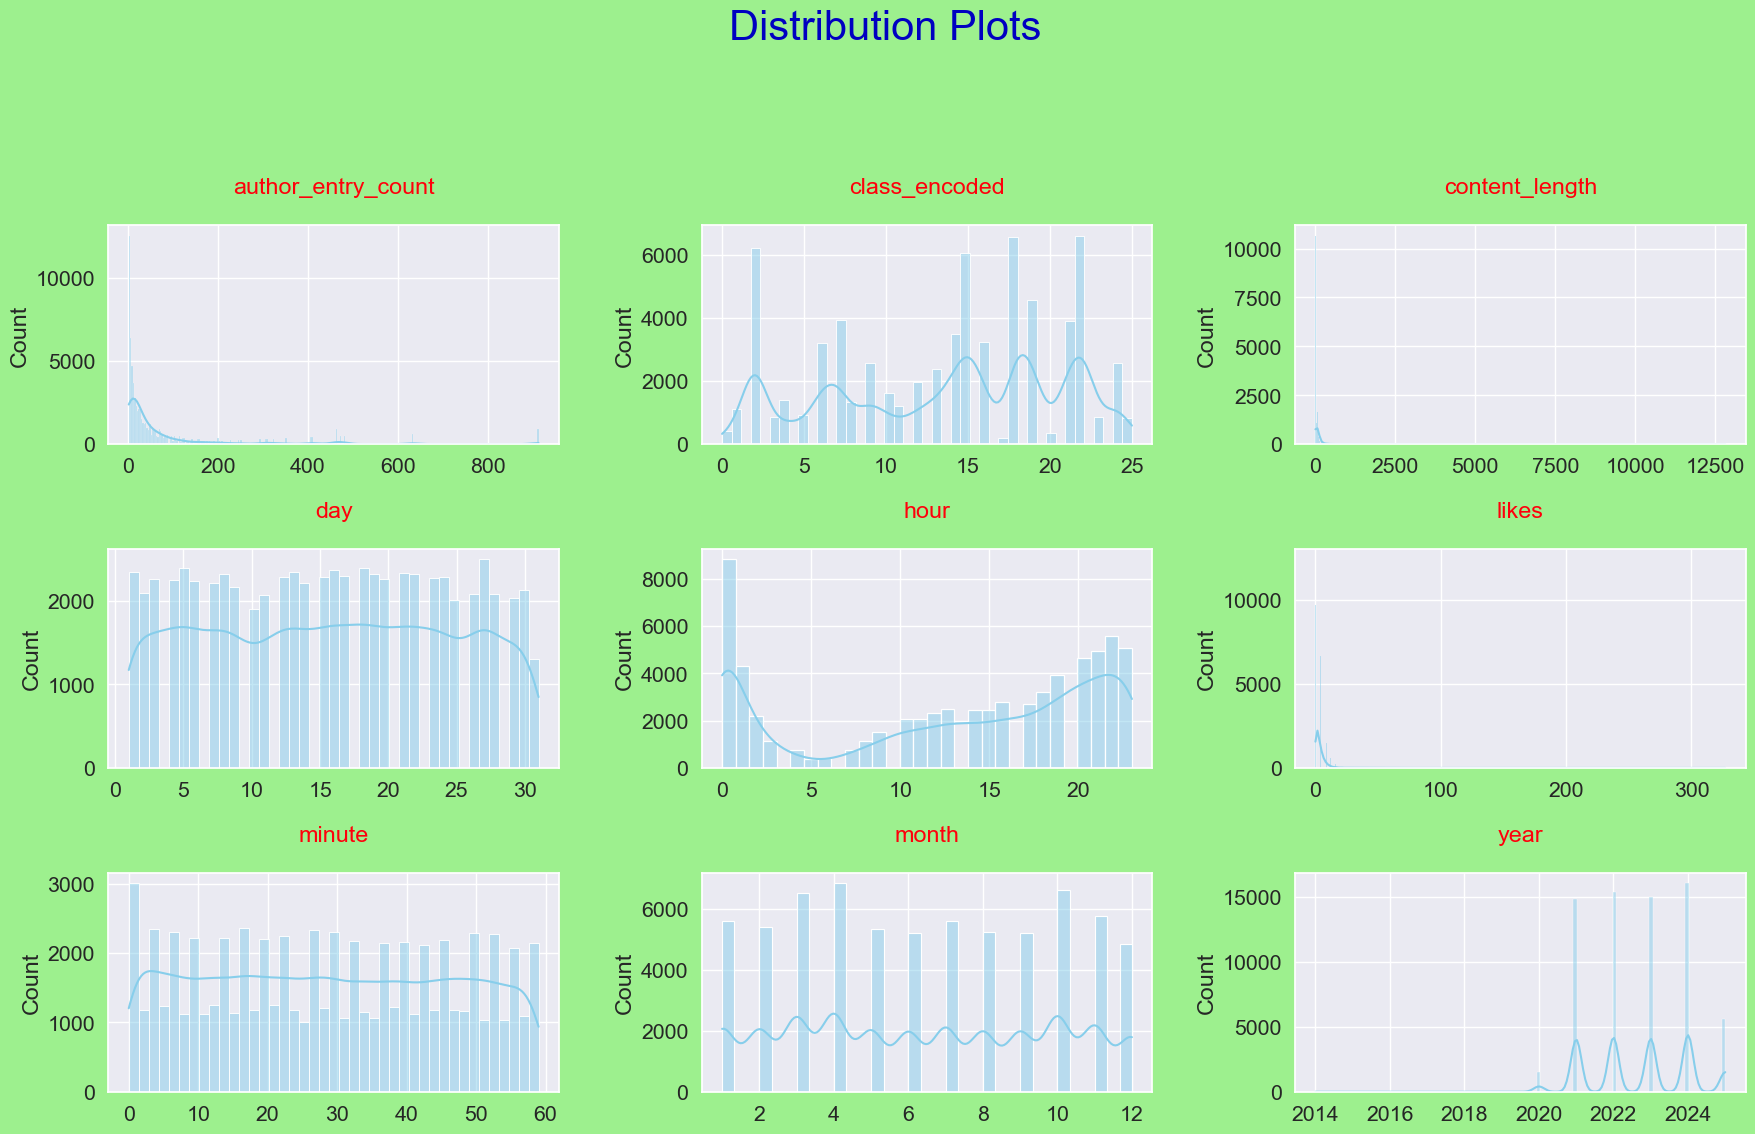

In [26]:
def plot_numeric_distributions(df, title='Distribution Plots'):
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = numeric_cols.difference(['id', 'index', 'author_id']) 
    n_cols = 3
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    plt.figure(figsize=(6*n_cols, 4*n_rows), facecolor='#9DF08E')
    plt.suptitle(f'{title}\n', color='#0000C1', size=30)

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.title(f'{col}\n', color='#FF000B')
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.xlabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_numeric_distributions(df_numeric)

Text(0.5, 1.0, 'Number of Entries by Year\n')

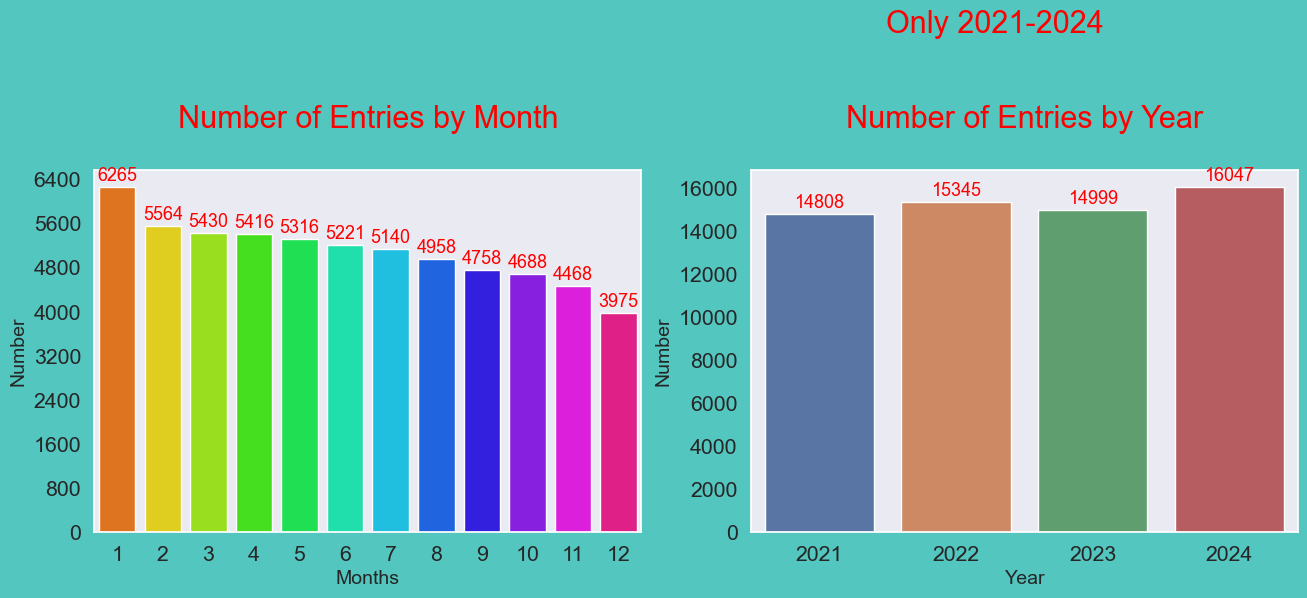

In [27]:
df_filtered = df[(df['year'] >= 2021) & (df['year'] <= 2024)]
plt.figure(figsize=(24,16),facecolor='#54C6C0')
plt.suptitle("Only 2021-2024", x=0.5, fontsize=22, color="red")

#-----

plt.subplot(3,3,1)
plots = sns.barplot(x=list(range(1,13)), y=df_filtered['month'].value_counts(), palette="hsv")  

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=13, xytext=(0, 8),
                   textcoords='offset points',color='red')
    
plt.xlabel("Months", size=14)
plt.ylabel("Number", size=14)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.grid(False)
plt.title("Number of Entries by Month\n", color="red", size='22')

#-----

plt.subplot(3,3,2)

# Count and sort the frequencies of the years
year_counts = df_filtered['year'].value_counts().sort_index()

# Barplot
plots = sns.barplot(x=year_counts.index, y=year_counts.values, palette="deep")

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=13, xytext=(0, 8),
                   textcoords='offset points',color='red')
    
plt.xlabel("Year", size=14)
plt.ylabel("Number", size=14)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.grid(False)
plt.title("Number of Entries by Year\n", color="red", size='22')

**• The graphs show that a large portion of the entries were unedited.**

**• Writers uploaded the most photos in January and their activity gradually decreased in the following months of the year.**

**• The distribution by year is quite balanced.**

Text(0.5, 1.0, 'Number of Entries by Hour\n')

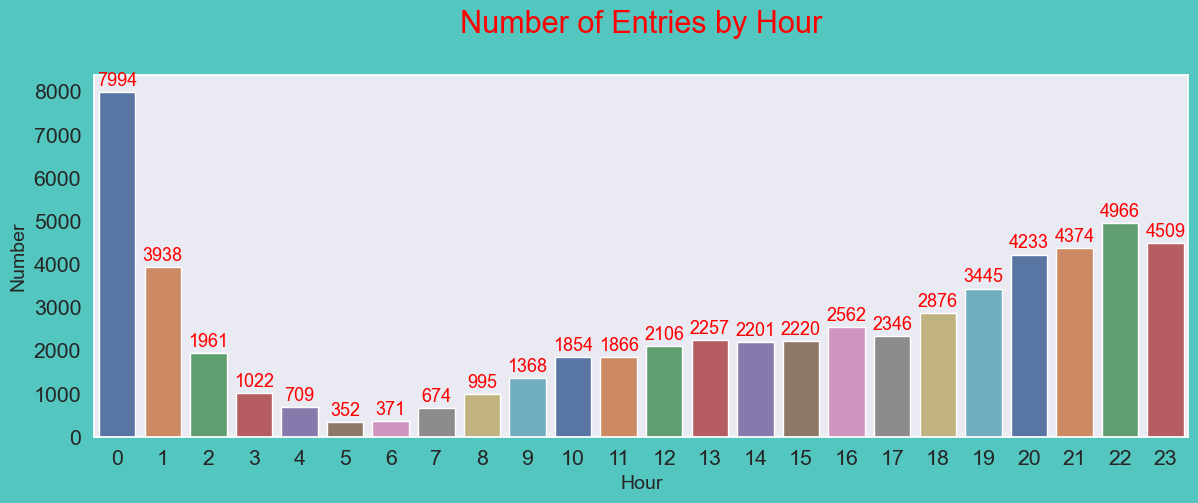

In [28]:
plt.figure(figsize=(48,16),facecolor='#54C6C0')
plt.subplot(3,3,3)

# Count and sort the frequencies of the hours
hour_counts = df_filtered['hour'].value_counts().sort_index()

# Barplot
plots = sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="deep")

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=13, xytext=(0, 8),
                   textcoords='offset points',color='red')
    
plt.xlabel("Hour", size=14)
plt.ylabel("Number", size=14)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
plt.grid(False)
plt.title("Number of Entries by Hour\n", color="red", size='22')

**Most Active Time Periods: 00:00–01:00 and 20:00–23:00**

•The peak occurs during the 00:00–01:00 time slot with 7994 entries, showing that users are highly active just after midnight.

•The 20:00–23:00 evening window also shows significant activity, with entries ranging from 4233 to 4966, indicating high user engagement during these hours.

This suggests that users are most engaged during late-night and evening hours, often choosing these periods for content creation.

**Least Active Time Periods: 05:00–06:00**

•At 05:00, only 352 entries were made, and 371 entries at 06:00.

•These are hours when most people are likely asleep or show minimal activity on digital platforms.

In summary, **content production peaks during late-night and evening hours**, while **early mornings see the lowest activity levels.**

# Total likes

In [29]:
df_class_stats = df.groupby("class")["likes"].agg(["count", "mean", "median"])
df_class_stats_sorted_by_count = df_class_stats.sort_values(by='count', ascending=False)
df_class_stats_sorted_by_count

count      mean  median
class                                
sunset         6597  3.762013     3.0
sea            6550  4.183664     3.0
architecture   6205  4.195488     3.0
landscape      6052  3.938863     3.0
sky            4576  3.763549     2.0
city           3920  4.134949     3.0
street         3894  4.303287     3.0
lake           3481  4.036484     3.0
nature         3231  3.930362     3.0
cat            3196  3.789737     3.0
flower         2572  3.676128     3.0
tree           2555  3.879452     3.0
indoor         2392  3.826505     2.0
human          1967  4.341129     3.0
food           1628  3.587838     2.0
bird           1399  3.802716     3.0
dog            1342  4.108793     2.0
forest         1215  4.163786     3.0
animal         1119  4.122431     3.0
car             910  3.493407     2.0
beach           856  3.584112     3.0
technology      847  3.514758     2.0
vehicle         823  3.721750     2.0
abstract        410  3.634146     2.0
sports          347  4.293948     3.0
ocean           204  3.617647     2.0

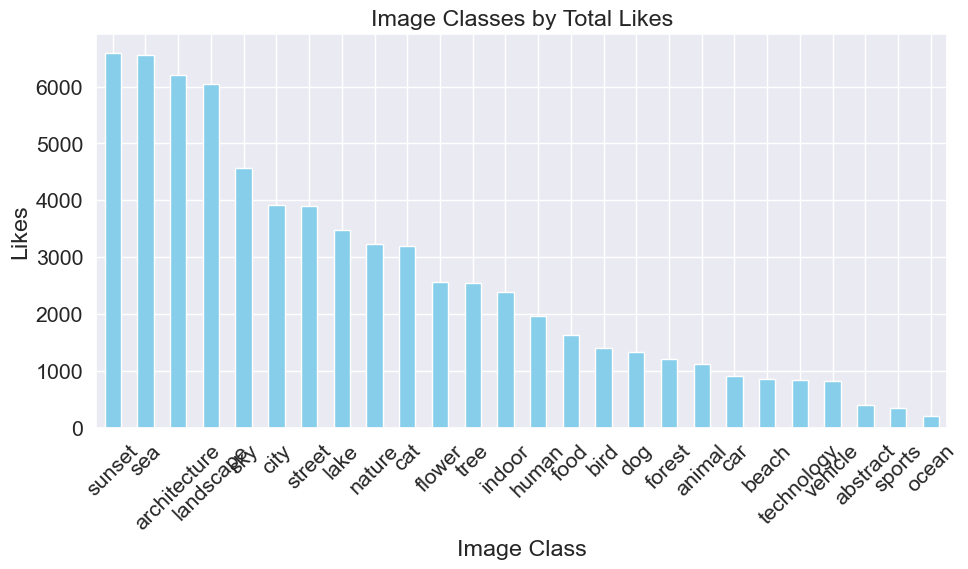

In [30]:
df_class_stats_sorted_by_count['count'].plot(kind="bar", figsize=(10,6), title = "Image Classes by Total Likes", color="skyblue")
plt.ylabel("Likes")
plt.xlabel("Image Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average likes

In [31]:
df_class_stats_sorted_by_mean = df_class_stats.sort_values(by='mean', ascending=False)
df_class_stats_sorted_by_mean

count      mean  median
class                                
human          1967  4.341129     3.0
street         3894  4.303287     3.0
sports          347  4.293948     3.0
architecture   6205  4.195488     3.0
sea            6550  4.183664     3.0
forest         1215  4.163786     3.0
city           3920  4.134949     3.0
animal         1119  4.122431     3.0
dog            1342  4.108793     2.0
lake           3481  4.036484     3.0
landscape      6052  3.938863     3.0
nature         3231  3.930362     3.0
tree           2555  3.879452     3.0
indoor         2392  3.826505     2.0
bird           1399  3.802716     3.0
cat            3196  3.789737     3.0
sky            4576  3.763549     2.0
sunset         6597  3.762013     3.0
vehicle         823  3.721750     2.0
flower         2572  3.676128     3.0
abstract        410  3.634146     2.0
ocean           204  3.617647     2.0
food           1628  3.587838     2.0
beach           856  3.584112     3.0
technology      847  3.514758     2.0
car             910  3.493407     2.0

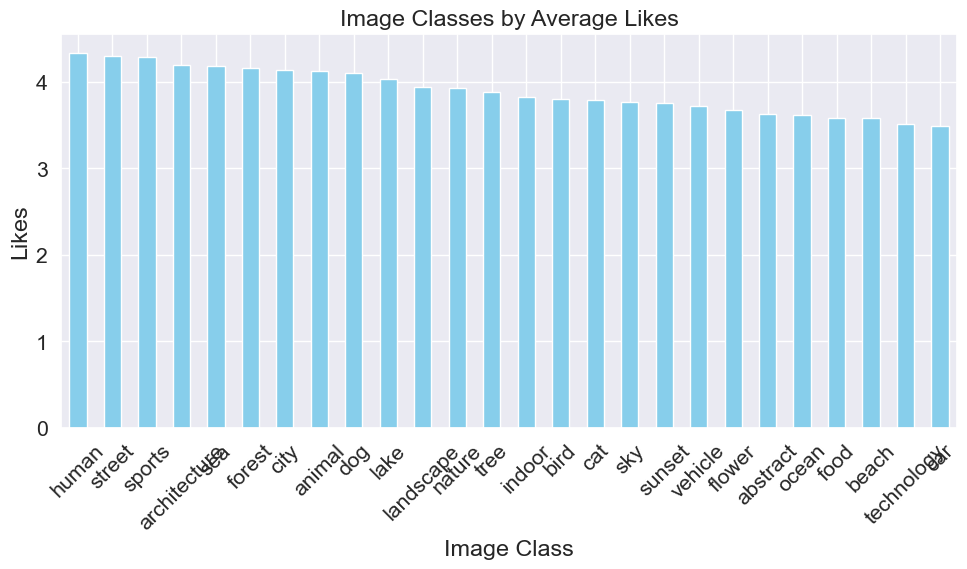

In [32]:
df_class_stats_sorted_by_mean['mean'].plot(kind="bar", figsize=(10,6), title = "Image Classes by Average Likes", color="skyblue")
plt.ylabel("Likes")
plt.xlabel("Image Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Author-based class preferences


In [33]:
# 1- Top 10 most liked authors
top_authors = df['author_name'].value_counts().head(10).index.tolist()
author_pref = df[df['author_name'].isin(top_authors)]

# Favorite image classes of the top 10 most liked authors
author_class_counts = pd.crosstab(author_pref['author_name'], author_pref['class'])

display(author_class_counts.T)

# 2- First 3rd class for authors
top_classes_per_author = {}

for author in author_class_counts.index:
    top_classes = author_class_counts.loc[author].sort_values(ascending=False).head(3).index.tolist()
    top_classes_per_author[author] = top_classes

print('author -> class1, class2, class3\n')
for author, top_classes in top_classes_per_author.items():
    print(f"{author} -> {', '.join(top_classes)}")

author_name   bunutartisabiliriz  cahil prof  hasansabbahinyegeni  \
class                                                               
abstract                       2           3                    4   
animal                         6           5                    9   
architecture                  13          16                   53   
beach                          1          11                   10   
bird                           4           3                    8   
car                            0           4                   10   
cat                           13           5                   20   
city                          18          14                   22   
dog                            8          10                   13   
flower                        15           7                   10   
food                           6          40                   12   
forest                         9           6                    8   
human                          7           5                   10   
indoor                         5          11                   26   
lake                          47          49                   31   
landscape                     53          26                   35   
nature                        36          25                   15   
ocean                          0           1                    0   
sea                           28          66                   34   
sky                           24          14                   35   
sports                         1           2                    5   
street                        13          24                   26   
sunset                        29          76                   53   
technology                     2          10                    7   
tree                           9          11                   18   
vehicle                        1          20                    8   

author_name   hukukihayat  lliure  nickbulamadimyalan  okur oldum mutlu oldum  \
class                                                                           
abstract                1       4                   6                       4   
animal                  9       5                   4                       6   
architecture           49      54                  35                      35   
beach                   1       6                   3                       6   
bird                    7      10                   8                       4   
car                     9       3                   5                       6   
cat                    23      25                  24                      12   
city                   31      16                  34                      19   
dog                     5       7                   6                       4   
flower                  3      17                   8                       8   
food                   15       5                   9                       9   
forest                  5      12                   2                       5   
human                  56      14                  10                       5   
indoor                 23      15                  19                      16   
lake                   15      23                  29                      17   
landscape              31      42                  32                      29   
nature                 20      18                  18                      22   
ocean                   2       3                   0                       0   
sea                    31      51                  38                      38   
sky                    17      25                  28                      26   
sports                  3       4                   2                       3   
street                 65      25                  30                      10   
sunset                 30      48                  24                      26   
technology              5       7         

author -> class1, class2, class3

bunutartisabiliriz -> landscape, lake, nature
cahil prof -> sunset, sea, lake
hasansabbahinyegeni -> architecture, sunset, landscape
hukukihayat -> street, human, architecture
lliure -> architecture, sea, sunset
nickbulamadimyalan -> sea, architecture, city
okur oldum mutlu oldum -> sea, architecture, landscape
polarstarr -> architecture, landscape, sunset
prhn -> architecture, street, sea
robert denir ona -> landscape, nature, sunset


# Distribution of likes by class

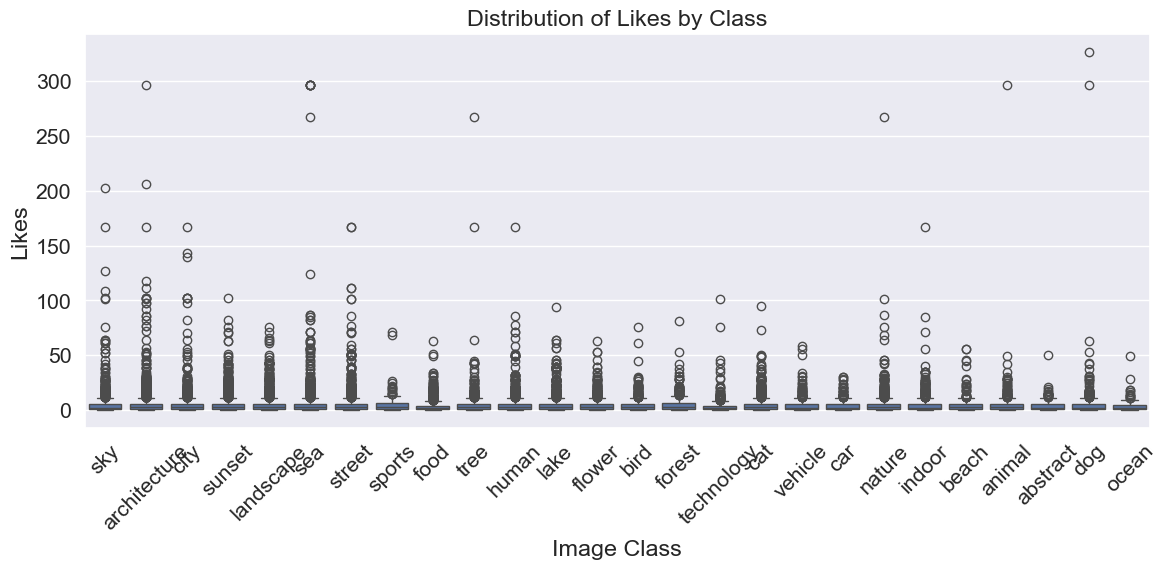

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="class", y="likes")
plt.xticks(rotation=45)
plt.title("Distribution of Likes by Class")
plt.xlabel("Image Class")
plt.ylabel("Likes")
plt.tight_layout()
plt.show()

# Distribution of likes

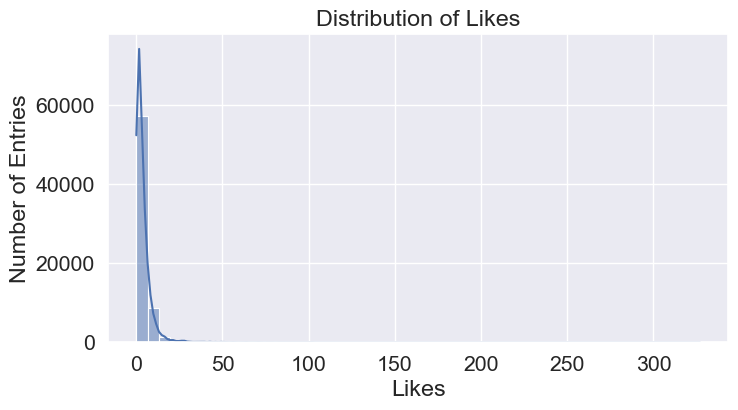

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(df["likes"], bins=50, kde=True)
plt.title("Distribution of Likes")
plt.xlabel("Likes")
plt.ylabel("Number of Entries")
plt.xticks(range(int(df["likes"].min()), int(df["likes"].max()) + 1, 50))
plt.show()

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>6. FEATURE ENGINEERING</strong></p>

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">1. Is Edited

### Create a new column: 'is_edited'

In [38]:
# True = 1, False = 0
df['is_edited'] = df['edit_date'].notnull().astype(int) 
cols = df.columns.tolist()
new_cols = cols[:7] + [cols[-1]] + cols[7:-1]
df = df[new_cols]
df.tail(3)

class_encoded         class  index  \
68286              2  architecture  68287   
68287             15     landscape  68288   
68288             13        indoor  68289   

                                                     url  likes  \
68286  https://cdn.eksisozluk.com/2025/4/23/p/prp0bk3...      0   
68287  https://cdn.eksisozluk.com/2025/4/23/t/tvilfek...      0   
68288  https://cdn.eksisozluk.com/2025/4/23/p/psbd137...      0   

                     date edit_date  content_length  author_entry_count  \
68286 2025-04-23 11:27:00       NaN             124                 7.0   
68287 2025-04-23 11:27:00       NaN             124                 7.0   
68288 2025-04-23 11:27:00       NaN             124                 NaN   

       is_edited         id  \
68286          0  174758095   
68287          0  174758095   
68288          0  174758095   

                                                 content author_name  \
68286  güzellik, düzenli olmak değil; doğallığın için...     oflumst   
68287  güzellik, düzenli olmak değil; doğallığın için...     oflumst   
68288  güzellik, düzenli olmak değil; doğallığın için...     oflumst   

       author_id                                               path  day  \
68286    1675419  C:\Users\soner.kar\Desktop\My Projects\SözlükL...   23   
68287    1675419  C:\Users\soner.kar\Desktop\My Projects\SözlükL...   23   
68288    1675419  C:\Users\soner.kar\Desktop\My Projects\SözlükL...   23   

       month  year  hour  minute  
68286      4  2025    11      27  
68287      4  2025    11      27  
68288      4  2025    11      27

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">2. Multiple Features

**Feature List:**

- **Contrast**

- **Brightness**

- **Sharpness**

- **Entropy**

- **Edge Density**

- **Blurriness**

- **Colorfulness**

- **Average Hue**

- **Average Saturation**

- **Image Area**

- **Aspect Ratio**

- **Is Grayscale**

- **File Size KB**

In [42]:
# --------- GET IMAGES ---------
def get_img(img_path, mode='L'):
    try:
        img = Image.open(img_path).convert(mode)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None

# --------- EXTRACT FEATURES ---------
def my_feature_extractor(img_path):
    features = {}
    try:
        # Grayscale and RGB data
        gray = get_img(img_path, mode='L')
        rgb = get_img(img_path, mode='RGB')
        
        if gray is None or rgb is None:
            raise ValueError("Image could not be loaded")

        # Width, Height, Area
        img_pil = Image.open(img_path)
        width, height = img_pil.size
        features["image_area"] = width * height
        features["aspect_ratio"] = width / height

        # Grayscale metrics
        features["contrast"] = gray.std()
        features["brightness"] = gray.mean()
        features["sharpness"] = cv2.Laplacian(gray, cv2.CV_64F).var()
        features["entropy"] = shannon_entropy(gray)
        features["edge_density"] = np.sum(cv2.Canny(gray, 100, 200) > 0) / gray.size
        features["blurriness"] = cv2.Laplacian(gray, cv2.CV_64F).var()

        # RGB metrics
        R, G, B = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
        rg = np.abs(R - G)
        yb = np.abs(0.5 * (R + G) - B)
        colorfulness = np.sqrt(np.std(rg)**2 + np.std(yb)**2) + 0.3 * np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)
        features["colorfulness"] = colorfulness

        # HSV metrics
        hsv = Image.fromarray(rgb.astype(np.uint8)).convert('HSV')
        h, s, v = hsv.split()
        features["average_hue"] = np.mean(np.array(h))
        features["average_saturation"] = np.mean(np.array(s))

        # Grayscale control
        '''
        #bgr = cv2.imread(img_path)
        #features["is_grayscale"] = int(len(bgr.shape) < 3 or np.allclose(bgr[:, :, 0], bgr[:, :, 1]) and np.allclose(bgr[:, :, 0], bgr[:, :, 2]))
        '''
        rgb_img = Image.open(img_path).convert("RGB")
        r, g, b = rgb_img.split()
        is_gray = np.all(np.array(r) == np.array(g)) and np.all(np.array(r) == np.array(b))
        features["is_grayscale"] = int(is_gray)
        
        # File Size
        features["file_size_kb"] = round(os.path.getsize(img_path) / 1024, 2)

    except Exception as e:
        print(f"Feature extraction failed for {img_path}: {e}")
        for key in ["contrast", "brightness", "sharpness", "entropy", "edge_density", "blurriness",
                    "colorfulness", "average_hue", "average_saturation", "image_area", "aspect_ratio",
                    "is_grayscale", "file_size_kb"]:
            features[key] = np.nan

    return features

# --------- SHOW IMAGES ---------
def show_images(img_paths, cols=5):
    cols = int(len(img_paths)/2)
    rows = (len(img_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].set_title(f"Ex-{i}")
        axs[i].axis("off")

    # Remove empty subplots
    for j in range(i+1, len(axs)):
        axs[j].axis("off")

    fig.suptitle('Examples for Feature Extraction', fontsize=30, color='#B85042')
    plt.tight_layout()
    plt.show()

# --------- SHOW METRICS ---------
def show_metrics(img_paths):
    features = [my_feature_extractor(p) for p in img_paths]
    df = pd.DataFrame(features)
    df.index = range(1, len(df) + 1)
    display(df.T.round(1))

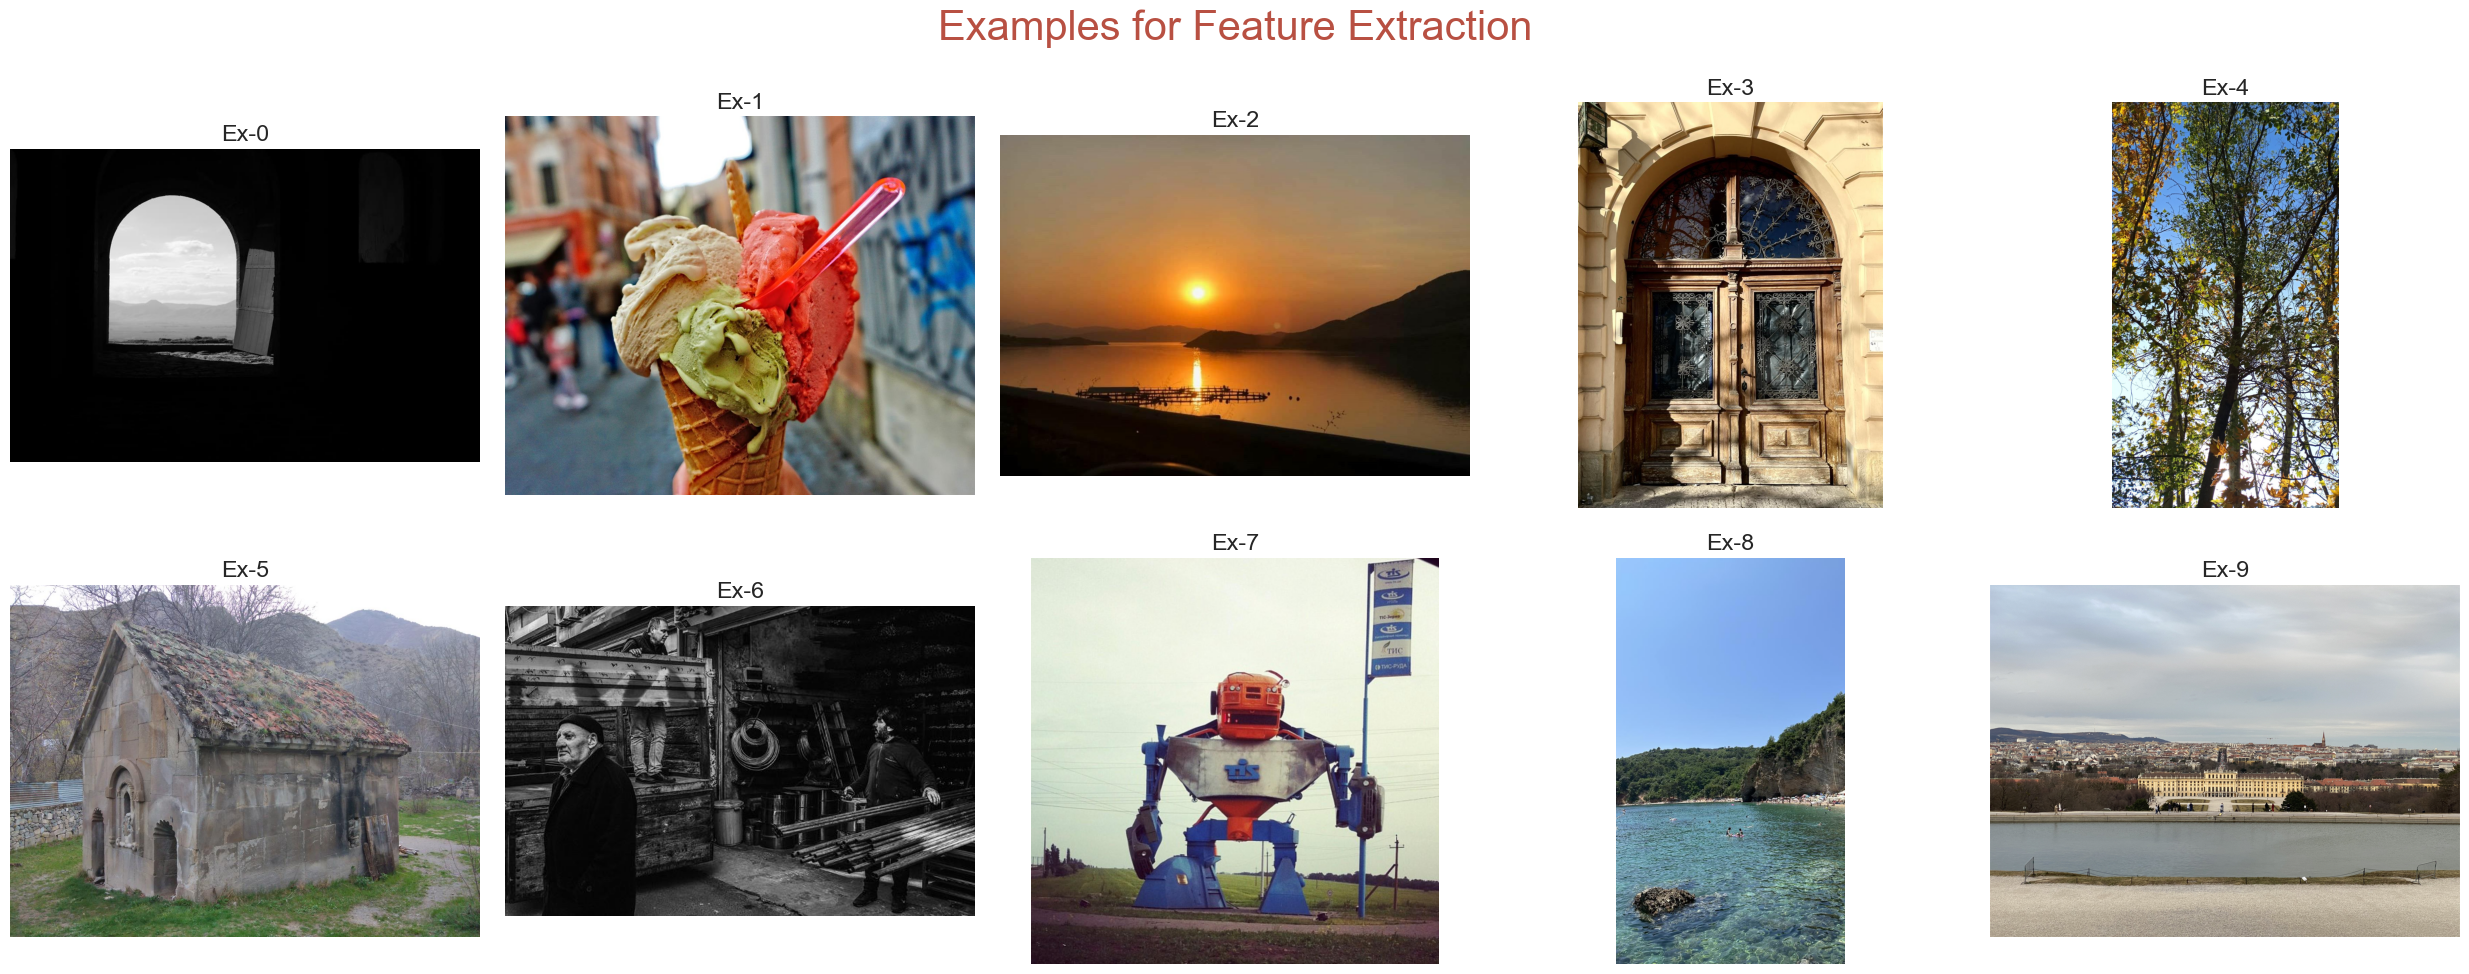

1          2         3          4          5   \
image_area          578772.0  1319680.0  847800.0  1080000.0  2940160.0   
aspect_ratio             1.5        1.2       1.4        0.8        0.6   
contrast                66.2       48.2      53.7       80.3       77.4   
brightness              27.5      117.6      93.8      119.7      105.0   
sharpness              105.1      108.6      36.1     2181.8     5754.3   
entropy                  3.6        7.4       6.8        7.9        7.7   
edge_density             0.0        0.0       0.0        0.1        0.2   
blurriness             105.1      108.6      36.1     2181.8     5754.3   
colorfulness            44.8      154.0      64.8       99.0      173.6   
average_hue              0.0       74.1      21.5       39.3       85.0   
average_saturation       0.0      101.1     147.0      113.5      109.7   
is_grayscale             1.0        0.0       0.0        0.0        0.0   
file_size_kb            19.9      152.1      37.8      203.7      986.3   

                           6         7          8         9          10  
image_area          1228800.0  342720.0  1364220.0  810000.0  1228800.0  
aspect_ratio              1.3       1.5        1.0       0.6        1.3  
contrast                 44.1      43.8       80.2      49.1       51.0  
brightness              123.5      43.3      166.6     133.1      160.5  
sharpness              1165.4    1578.9       92.9    2266.9     1479.2  
entropy                   7.0       6.7        7.0       7.3        7.1  
edge_density              0.1       0.1        0.0       0.2        0.1  
blurriness             1165.4    1578.9       92.9    2266.9     1479.2  
colorfulness            164.9      34.1      174.0     178.9      180.8  
average_hue             110.8       0.0       84.6     128.3       85.3  
average_saturation       31.2       0.0       50.3      90.4       33.1  
is_grayscale              0.0       1.0        0.0       0.0        0.0  
file_size_kb            226.0      61.1      116.2     135.5     2039.5

In [44]:
# --------- USE ---------
img_nums = [10,1000,10000,50000,60000,20,67449,20000,40000,65000]

img_paths = []
for i in img_nums:
    img_paths.append(downloaded_images+'img_'+str(i)+'.jpg')
    
show_images(img_paths)
show_metrics(img_paths)

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">3. Image Count Per Entry

### Create a new column: 'image_count_per_entry'

In [45]:
# Count how many images (rows) there are for each entry id
df['image_count_per_entry'] = df.groupby('id')['id'].transform('count')

In [47]:
df['image_count_per_entry'].tail(12)

68277    1
68278    3
68279    3
68280    3
68281    1
68282    1
68283    6
68284    6
68285    6
68286    6
68287    6
68288    6
Name: image_count_per_entry, dtype: int64

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">4. Extract All

In [50]:
features_list = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['path']
    features = my_feature_extractor(img_path)
    features_list.append(features)
    
features_df = pd.DataFrame(features_list)
df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
df.to_excel("10_dataset_processed.xlsx", index=False)
df.head()

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>7. ADVANCED EDA</strong></p>

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">1. Correlation Analysis (Again)

### Check null values

In [62]:
df.isnull().sum()

class_encoded                0
class                        0
index                        0
url                          0
likes                        0
date                         0
edit_date                65898
content_length               0
author_entry_count           0
is_edited                    0
id                           0
content                      0
author_name                  0
author_id                    0
path                         0
day                          0
month                        0
year                         0
hour                         0
minute                       0
image_count_per_entry        0
dtype: int64

**That's ok. There are no columns with null data except edit_date.**

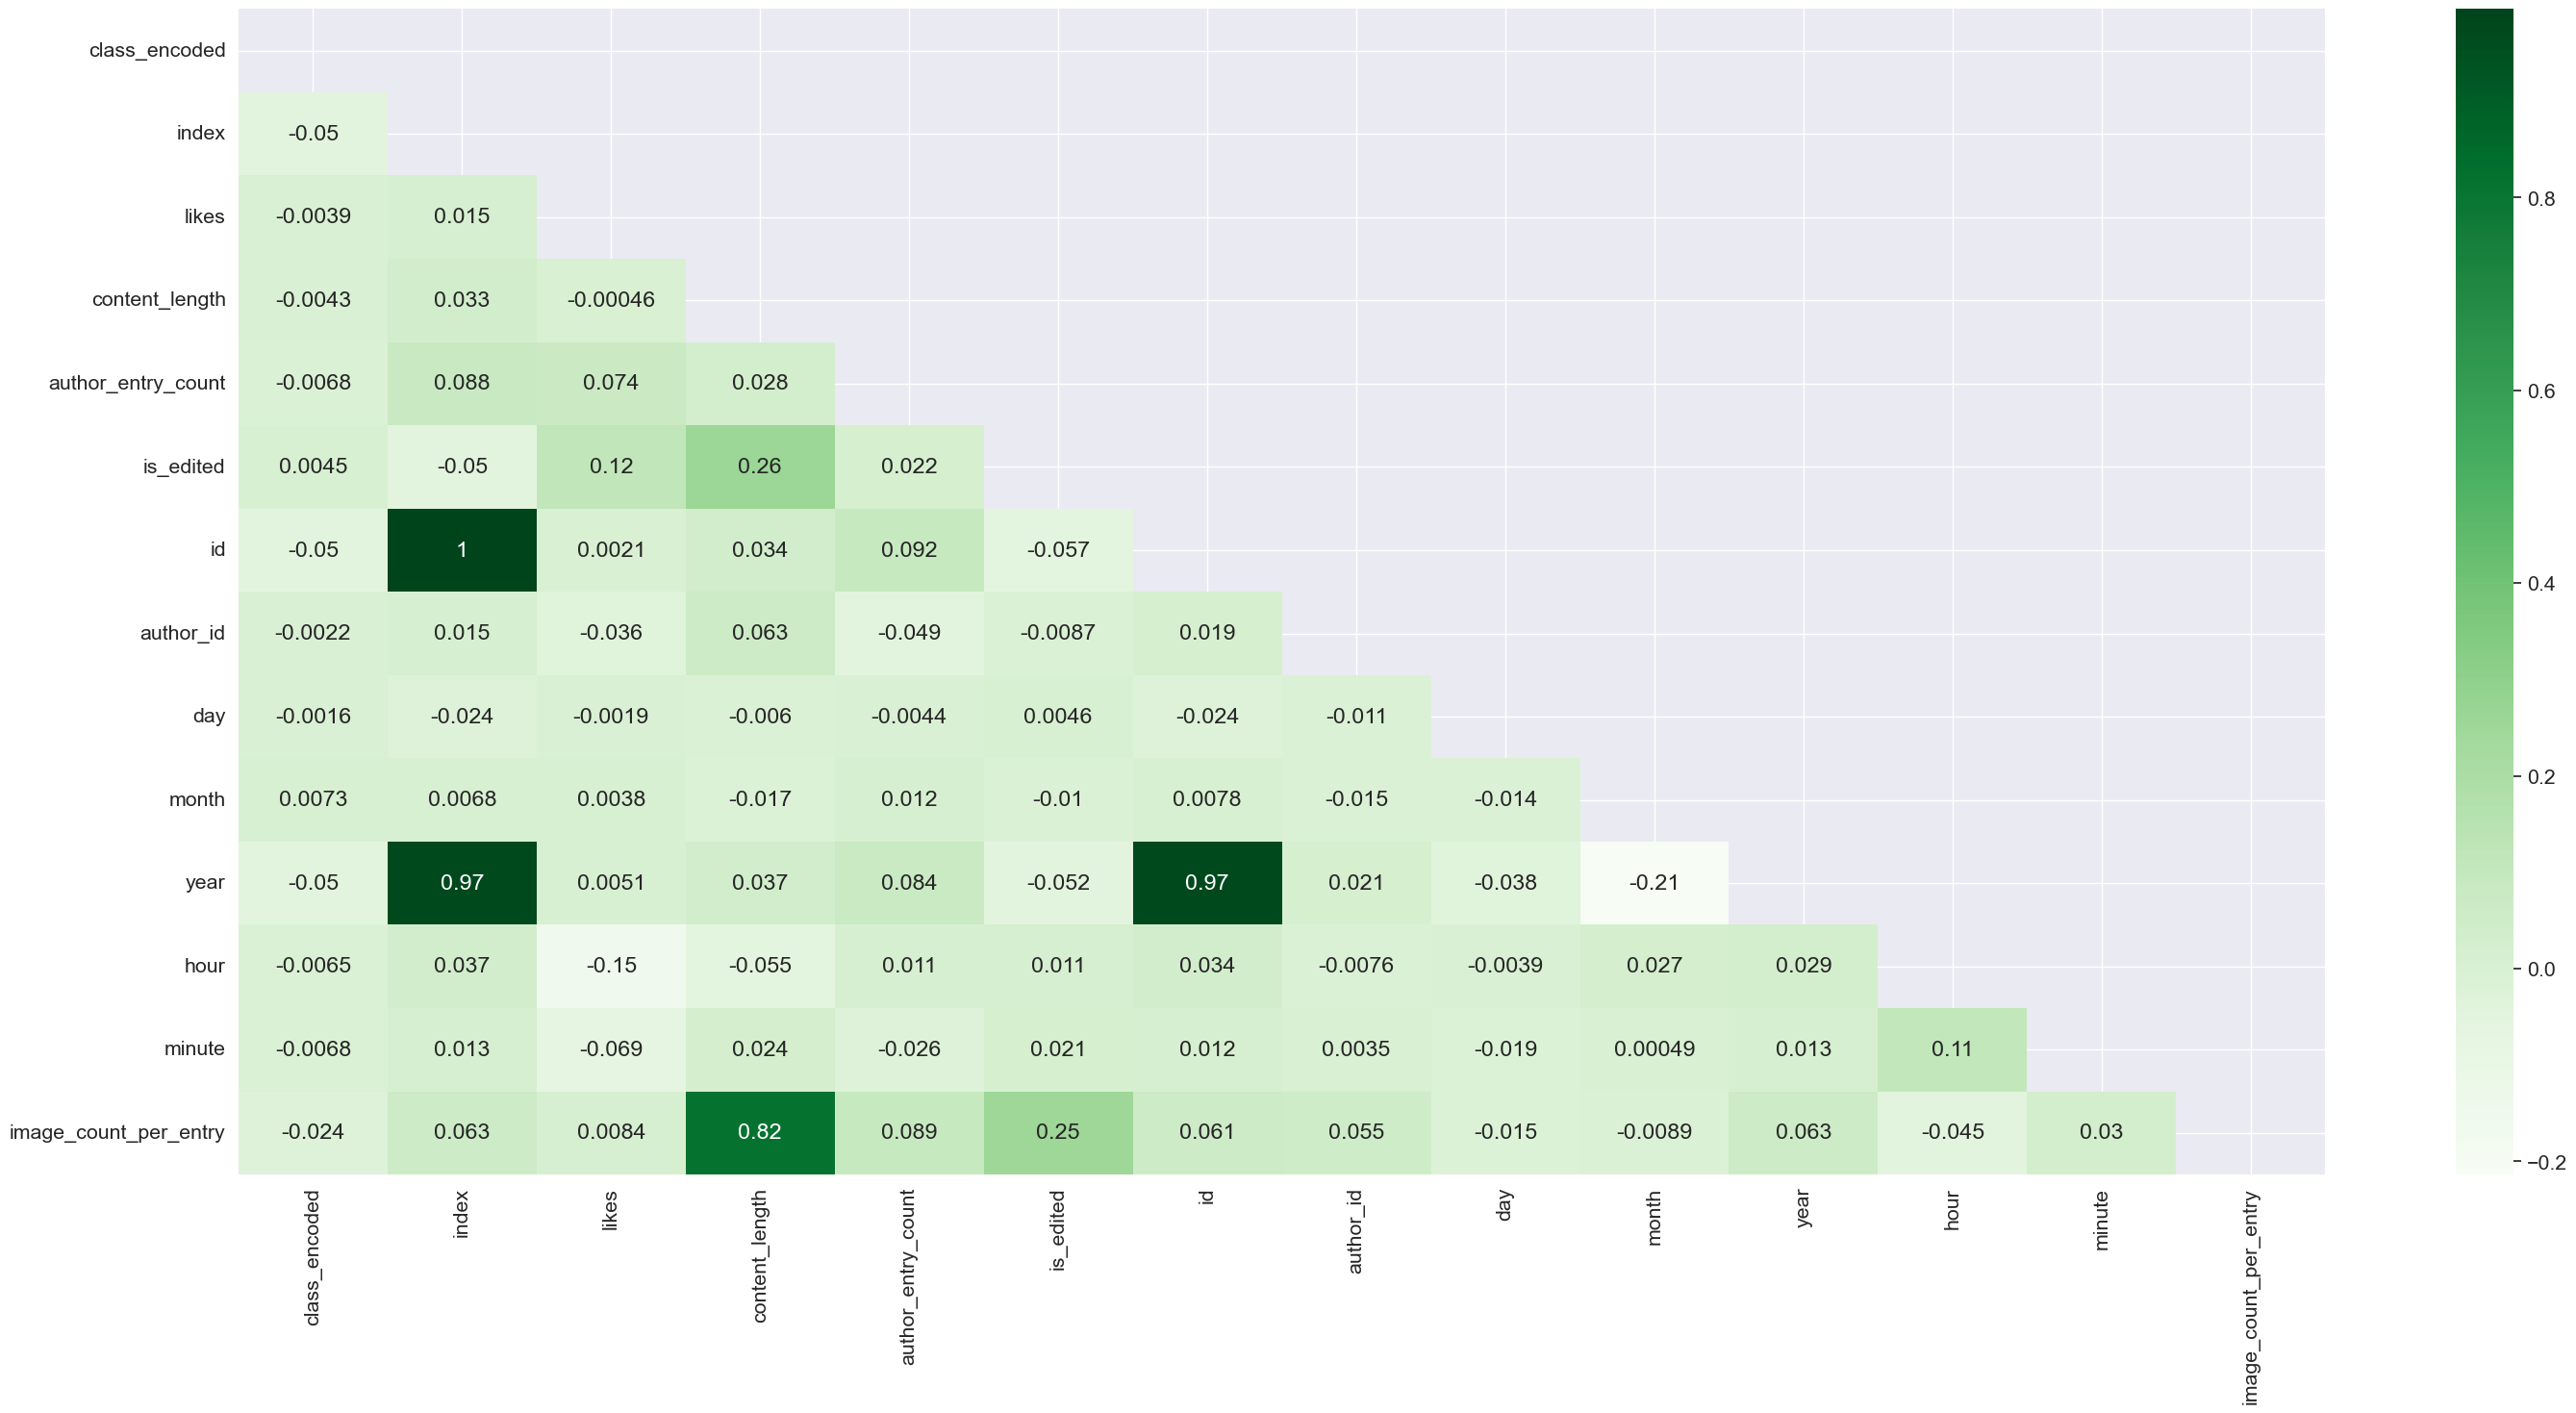

In [63]:
df_numeric = df.select_dtypes(include=['number'])
cor = df_numeric.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.set(font_scale=1.4)
plt.figure(figsize=(30,15))
sns.heatmap(cor, annot=True, mask=mask, cmap='Greens')
plt.tight_layout()
plt.show()

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">2. Distribution Plots

In [64]:
def plot_numeric_distributions(df, title='Distribution Plots'):
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = numeric_cols.difference(['id', 'index', 'author_id', 'minute']) 
    n_cols = 3
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    plt.figure(figsize=(6*n_cols, 4*n_rows), facecolor='#9DF08E')
    plt.suptitle(f'{title}\n', color='#0000C1', size=30)

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.title(f'{col}\n', color='#FF000B')
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.xlabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

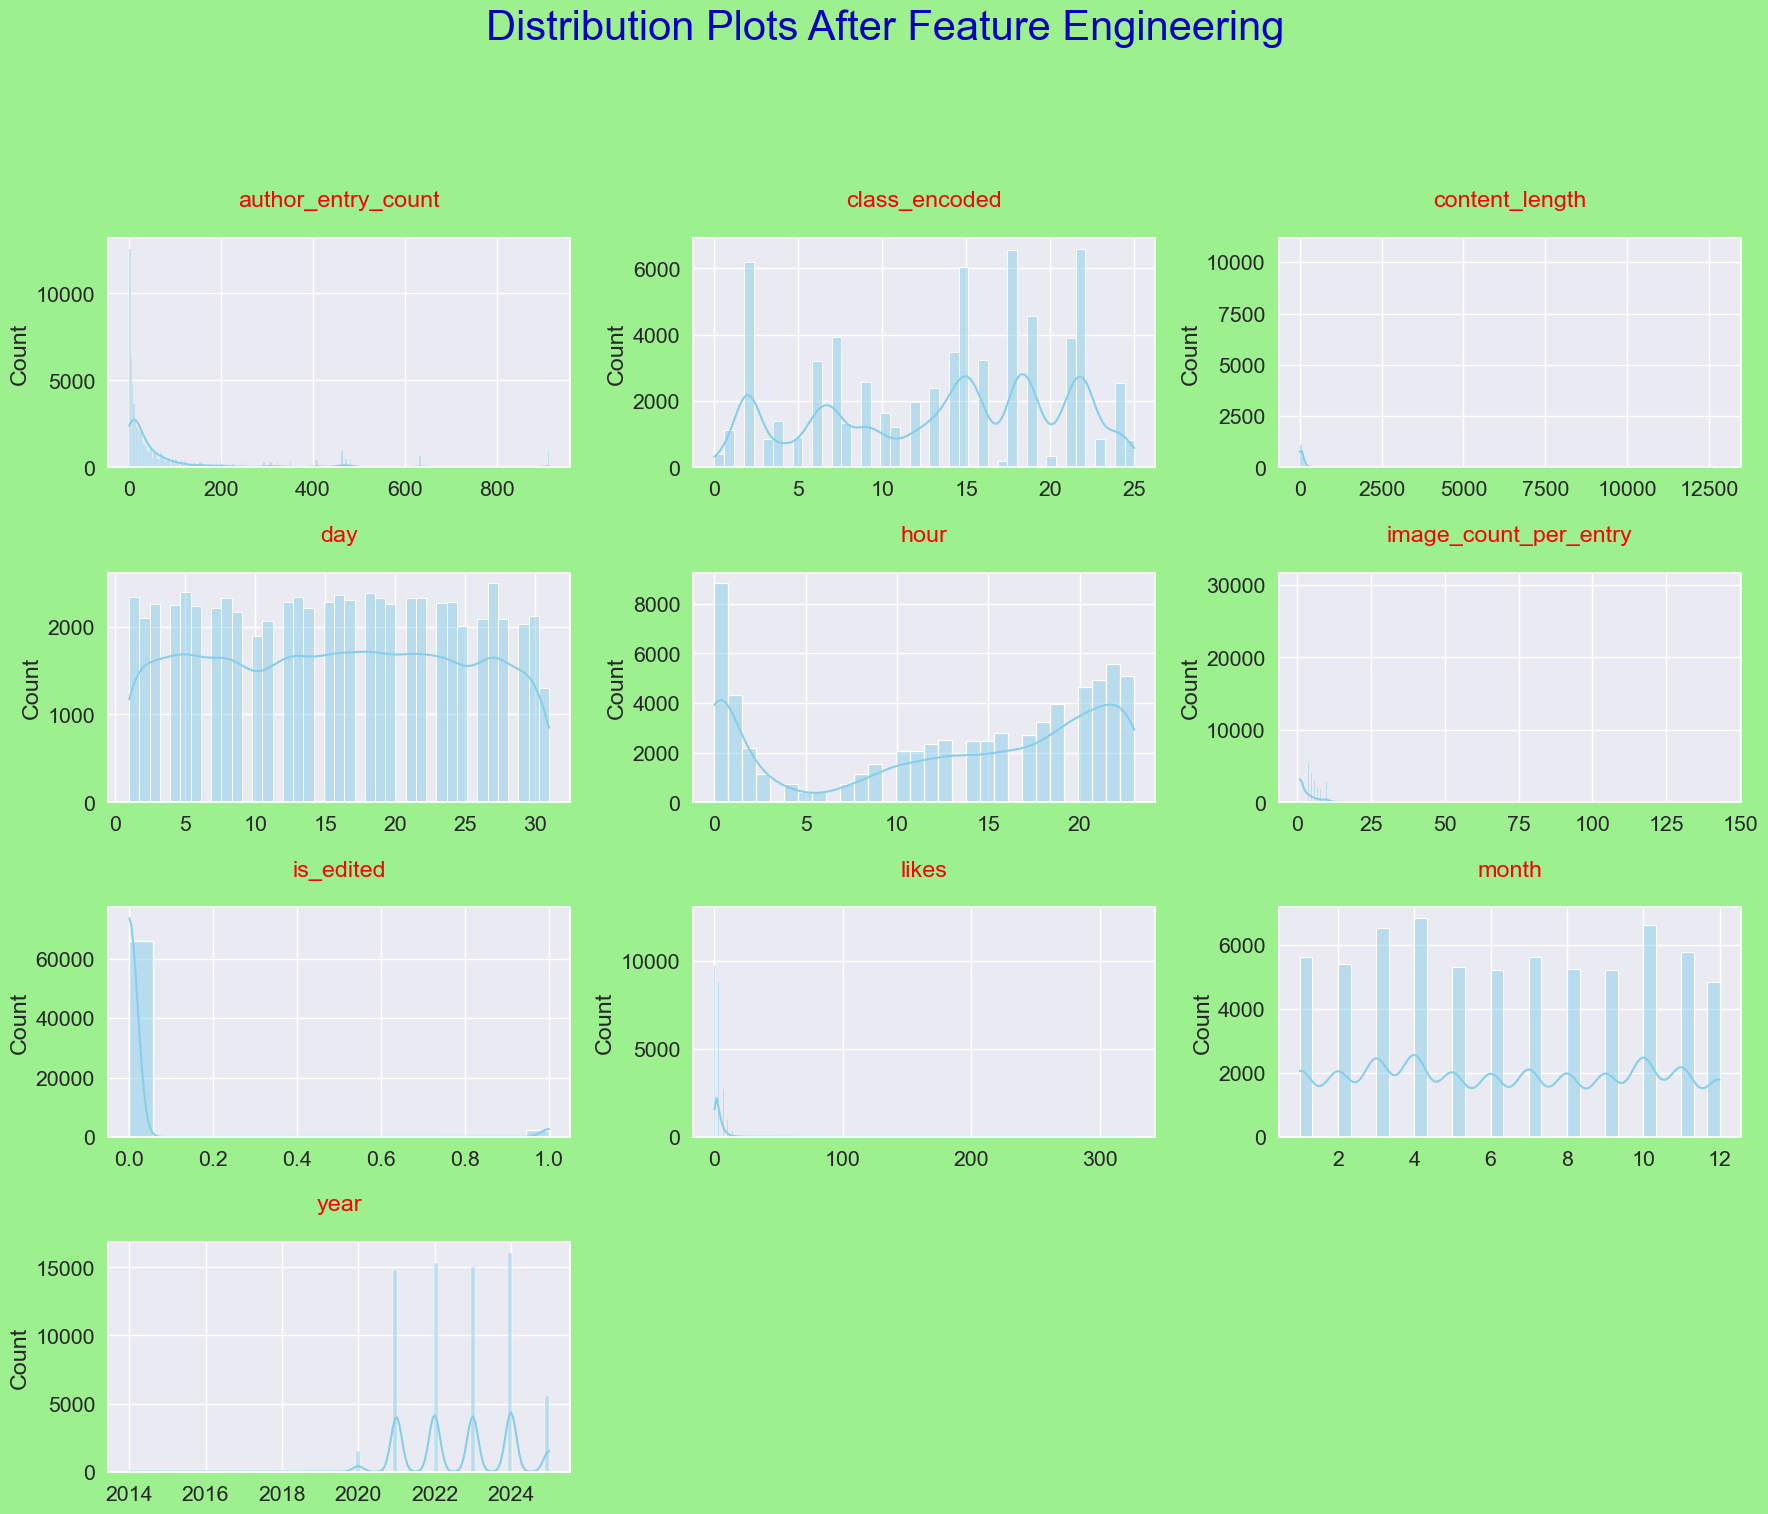

In [65]:
plot_numeric_distributions(df, title='Distribution Plots After Feature Engineering')

#####  **Balanced or Near Normal Distributions:**
- **Brightness and Contrast**: These features exhibit nearly normal distributions centered around moderate values. This indicates that most images are well-lit and moderately contrasted.
- **Average Hue and Colorfulness**: Both distributions are reasonably balanced, suggesting a healthy diversity in image coloration without extreme saturation or dullness.

#####  **Highly Right-Skewed Distributions:**
- **Bluriness**, **Sharpness**, **File Size**, **Image Area**, **Entry Length**, **Content Length**, **Likes**  
  This implies:
  - Most images are small, clear, and not blurry.
  - The majority of entries are short, but there are a few outliers with very large values.
  - Very few entries receive a high number of likes, indicating a typical long-tail distribution common in social media data.

#####  **Categorical or Numerically-Coded Categorical Features:**
- **Class Encoded**: A noticeable imbalance in class distribution suggests some classes are much more frequent than others, which should be addressed in modeling.
- **Time**:
  - **Hour**: Displays two strong peaks, with activity spiking around evening (20:00–23:00) and midnight (00:00–01:00), indicating popular posting hours.
  - **Month** & **Day**: Fairly uniform distributions, with no strong seasonal or daily posting trends.
  - **Year**: A strong increasing trend from 2022 to 2024, highlighting that the dataset is mostly composed of recent entries.

#####  **Binary Feature:**
- **is_edited**: The majority of entries are not edited, but a significant number of edited entries still exist, making it a potentially useful variable.

#####  **Other Notable Features:**
- **Entropy**: Peaks near the maximum, suggesting most images contain high information density.
- **Edge Density**: Exhibits an exponential decline; most images have low edge density, while only a few have high edge content.
- **Aspect Ratio**: Sharp spikes at certain ratios indicate the prevalence of standard formats like square, 3:2, or 4:3 images.


<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>8. REGRESSION</strong></p>

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">1. Model

In [66]:
df = pd.read_excel('10_dataset_processed.xlsx')
df.head(3)

class_encoded  index                                                url  \
0             19      1  https://cdn.eksisozluk.com/2014/9/2/y/ydqeqxbz...   
1              2      2  https://cdn.eksisozluk.com/2014/9/2/j/jukc5bb4...   
2              2      3  https://cdn.eksisozluk.com/2014/9/2/g/grh1enp8...   

   likes                date         edit_date  is_edited        id  \
0    102 2014-09-02 14:26:00  26.03.2021 00:00          1  45405875   
1    102 2014-09-02 14:26:00  26.03.2021 00:00          1  45405875   
2    102 2014-09-02 14:26:00  26.03.2021 00:00          1  45405875   

                                             content author_name  ...  \
0  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth  ...   
1  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth  ...   
2  pek aram yoktur fotoğraf ile ama şunları sever...     ciodeth  ...   

   class_sky  class_sports  class_street  class_sunset  class_technology  \
0       True         False         False         False             False   
1      False         False         False         False             False   
2      False         False         False         False             False   

   class_tree  class_vehicle file_size_kb  grayscale_0 grayscale_1  
0       False          False       106.62         True       False  
1       False          False       214.74         True       False  
2       False          False       301.77         True       False  

[3 rows x 60 columns]

# v1

In [67]:
# ML MODELS

# Label and columns to be dropped
label = 'likes'
drop_cols = ['index', 'url', 'date', 'id', 'edit_date', 'path', 'content', 'author_name', 'author_id', 'year_month']

# Features and label
df_filtered = df.drop(columns=drop_cols)
X = df_filtered.drop(columns=[label])
y = df_filtered[label]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'K Neighbors': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Huber Regression': HuberRegressor()
}
# Train and evaluate
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([model_name,round(rmse, 2), round(r2 * 100)])
    #######print(f"{model_name} - RMSE: {rmse:.2f}, R² Score: {r2:.2f}")
    
# Create results df 
df_results = pd.DataFrame(results, columns=['Model', 'RMSE', 'R² Score %'])
display(df_results)

Model   RMSE  R² Score %
0              Random Forest   5.05          51
1                    XGBoost   5.42          43
2                   LightGBM   5.43          43
3          Linear Regression   6.98           6
4  Support Vector Regression   7.29          -3
5              Decision Tree   7.09           3
6                K Neighbors   7.33          -4
7          Gradient Boosting   5.97          31
8                   AdaBoost  15.50        -364
9           Huber Regression   7.31          -3

<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">7.2. Importance of Features

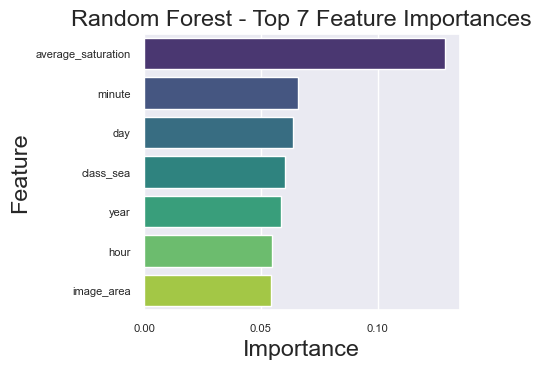

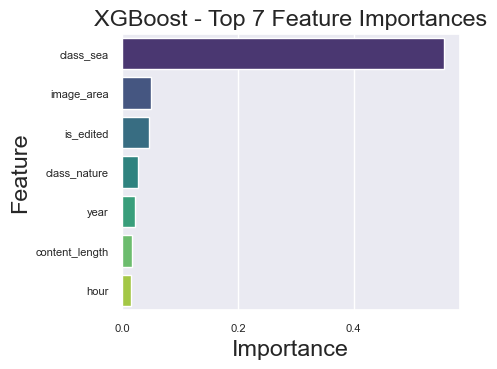

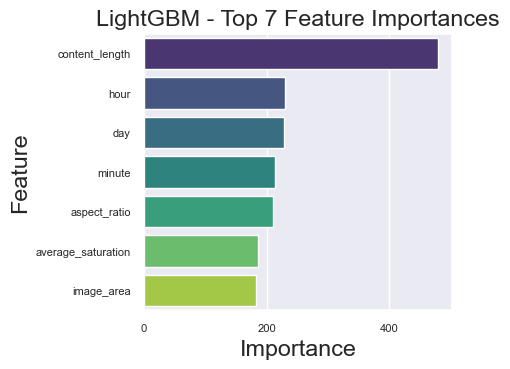

In [68]:
##### Feature Selection #####------------------------------------------------
# Önemli modeller
importance_models = ['Random Forest', 'XGBoost', 'LightGBM']

# Top 7 önemli özelliği toplayacağımız set
top_features_set = set()
number_of_features = 7

for model_name in importance_models:
    model = models[model_name]
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(number_of_features)
    
    # Grafik çiz
    plt.figure(figsize=(5, 4))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f"{model_name} - Top {number_of_features} Feature Importances")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

    # En önemli özellikleri kümeye ekle
    top_features_set.update(feature_importance_df['Feature'].tolist())

# Listeye çevir
top_features = list(top_features_set)

In [69]:
print('All Importance of Features')
for model_name in importance_models:
    model = models[model_name]
    print(f'         -{model_name}-')
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    display(feature_importance_df)
    print('\n\n--------------------------------\n\n')

All Importance of Features
         -Random Forest-


Feature  Importance
16  average_saturation    0.128635
6               minute    0.065923
2                  day    0.063905
38           class_sea    0.060404
4                 year    0.058522
5                 hour    0.054687
13          image_area    0.054468
8         entry_length    0.052632
7       content_length    0.052480
1            is_edited    0.047160
14        aspect_ratio    0.038601
10          brightness    0.035375
15         average_hue    0.030722
46        file_size_kb    0.029754
12        colorfulness    0.028949
9             contrast    0.028926
3                month    0.027744
18             entropy    0.024714
17        edge_density    0.023907
19          blurriness    0.019126
11           sharpness    0.018228
0        class_encoded    0.011187
34          class_lake    0.004802
32         class_human    0.004438
36        class_nature    0.003546
39           class_sky    0.003355
42        class_sunset    0.003234
35     class_landscape    0.002821
41        class_street    0.002421
26           class_cat    0.002245
33        class_indoor    0.002143
29        class_flower    0.001816
27          class_city    0.001410
28           class_dog    0.001401
31        class_forest    0.001323
22  class_architecture    0.001284
47         grayscale_0    0.001051
24          class_bird    0.001043
44          class_tree    0.001030
40        class_sports    0.000765
43    class_technology    0.000721
25           class_car    0.000633
23         class_beach    0.000592
30          class_food    0.000591
21        class_animal    0.000422
48         grayscale_1    0.000314
45       class_vehicle    0.000242
37         class_ocean    0.000211
20      class_abstract    0.000094



--------------------------------


         -XGBoost-


Feature  Importance
38           class_sea    0.555165
13          image_area    0.050751
1            is_edited    0.047235
36        class_nature    0.028293
4                 year    0.021849
7       content_length    0.017589
5                 hour    0.015993
15         average_hue    0.015556
2                  day    0.015516
39           class_sky    0.014171
6               minute    0.013514
32         class_human    0.013372
34          class_lake    0.011632
3                month    0.011487
16  average_saturation    0.011425
14        aspect_ratio    0.010409
30          class_food    0.008911
43    class_technology    0.008881
41        class_street    0.008566
33        class_indoor    0.008470
0        class_encoded    0.008401
9             contrast    0.006905
40        class_sports    0.006072
23         class_beach    0.005982
11           sharpness    0.005855
31        class_forest    0.005826
28           class_dog    0.005725
12        colorfulness    0.005620
10          brightness    0.005545
25           class_car    0.005227
35     class_landscape    0.004965
42        class_sunset    0.004914
17        edge_density    0.004836
29        class_flower    0.004674
46        file_size_kb    0.004666
18             entropy    0.003860
27          class_city    0.003740
22  class_architecture    0.003229
24          class_bird    0.003013
21        class_animal    0.002826
26           class_cat    0.002745
44          class_tree    0.002729
47         grayscale_0    0.001935
37         class_ocean    0.001922
8         entry_length    0.000000
20      class_abstract    0.000000
19          blurriness    0.000000
45       class_vehicle    0.000000
48         grayscale_1    0.000000



--------------------------------


         -LightGBM-


Feature  Importance
7       content_length         479
5                 hour         230
2                  day         229
6               minute         214
14        aspect_ratio         211
16  average_saturation         186
13          image_area         182
4                 year         174
3                month         153
1            is_edited         113
10          brightness         102
9             contrast          86
11           sharpness          83
12        colorfulness          64
18             entropy          64
46        file_size_kb          64
15         average_hue          62
0        class_encoded          61
17        edge_density          55
36        class_nature          24
34          class_lake          22
38           class_sea          17
31        class_forest          15
42        class_sunset          13
43    class_technology          12
30          class_food          10
25           class_car          10
32         class_human           9
29        class_flower           9
35     class_landscape           8
40        class_sports           8
33        class_indoor           6
26           class_cat           6
27          class_city           6
44          class_tree           3
41        class_street           3
23         class_beach           2
39           class_sky           2
24          class_bird           2
22  class_architecture           1
8         entry_length           0
28           class_dog           0
19          blurriness           0
20      class_abstract           0
21        class_animal           0
37         class_ocean           0
45       class_vehicle           0
47         grayscale_0           0
48         grayscale_1           0



--------------------------------




<a id = "3"><p style = "font-size : 30px; color :#1976D2 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #E7E8D1; border-radius: 5px 5px;">7.3 Modeling After Feature Selection Based on Importance

In [70]:
##### Feature Selection #####------------------------------------------------
# Önemli modeller
importance_models = ['Random Forest', 'XGBoost', 'LightGBM']

# Top 10 önemli özelliği toplayacağımız set
top_features_set = set()

for model_name in importance_models:
    model = models[model_name]
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(10)
    
    # En önemli özellikleri ekle
    top_features_set.update(feature_importance_df['feature'].tolist())
    
    # Listeye çevir
    top_features = list(top_features_set)

# Listeye çevir
top_features = list(top_features_set)

print(f"Number of Top Important Features: {len(top_features)}")
print(f'Top Important Features: {top_features}')

Number of Top Important Features: 15
Top Important Features: ['minute', 'aspect_ratio', 'content_length', 'image_area', 'year', 'average_saturation', 'hour', 'entry_length', 'class_nature', 'day', 'class_sky', 'class_sea', 'average_hue', 'is_edited', 'month']


In [71]:
# Yeni X (sadece önemli özellikleri içeren)
X_selected = X[top_features]

# Split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Aynı modelleri tekrar eğit ve değerlendir

print(f'\n[Model Results With Important {len(top_features)} Features]')
results = []
for model_name, model in models.items():
    model.fit(X_train_sel, y_train_sel)
    y_pred = model.predict(X_test_sel)
    
    rmse = np.sqrt(mean_squared_error(y_test_sel, y_pred))
    r2 = r2_score(y_test_sel, y_pred)

    results.append([model_name, rmse, r2])
    
# sort and show
df_results = pd.DataFrame(results, columns=['Model', 'RMSE', 'R² Score %'])
display(df_results)


[Model Results With Important 15 Features]


Model       RMSE  R² Score %
0              Random Forest   4.718755    0.569784
1                    XGBoost   5.324992    0.452139
2                   LightGBM   5.400904    0.436408
3          Linear Regression   7.009549    0.050680
4  Support Vector Regression   7.289047   -0.026535
5              Decision Tree   6.642934    0.147387
6                K Neighbors   6.755318    0.118294
7          Gradient Boosting   5.935463    0.319322
8                   AdaBoost  15.290023   -3.516984
9           Huber Regression   7.312172   -0.033059

### save models

In [72]:
joblib.dump(models['Random Forest'], 'model_random_forest.pkl')
joblib.dump(models['XGBoost'], 'model_xgboost.pkl')
joblib.dump(models['LightGBM'], 'model_lightgbm.pkl')

['model_lightgbm.pkl']

### load models

In [ ]:
'''
rf_model = joblib.load('model_random_forest.pkl')
xgboost_model = joblib.load('model_xgboost.pkl')
lightgbm_model = joblib.load('model_lightgbm.pkl')

# selected models for feature importance
importance_models = {
    'Random Forest': rf_model,
    'XGBoost': xgboost_model,
    'LightGBM': lightgbm_model,
}
'''

<a id = "1"></a><p style = "font-size : 40px; color :#E7E8D1 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #B85042; border-radius: 5px 5px;"><strong>9. CONCLUSION</strong></p>

- Images were classified into 25 categories using the CLIP model. The most common categories include 'nature', 'human', 'animal', and 'landscape'.

- Analyzing the average number of favorites by image class showed that categories with emotional or aesthetic appeal (such as 'nature', 'cat', 'sunset', and 'sea')tended to receive more likes.

- In contrast, categories like 'technology', 'vehicle', and 'abstract' generally received fewer favorites. This suggests that users show greater interest in nature-themed and emotionally resonant visuals.

- Temporal distribution analysis revealed that users most frequently uploaded visual content at night, especially between 00:00–01:00. The number of uploads peaked in January and gradually declined over the following months.

- The vast majority of entries were not edited after being posted. Edits were relatively rare, indicating that users tend to leave their content unchanged.

- The length of entry content varied greatly, but there was no strong correlation between content length and the number of favorites.

- Technical visual metrics—such as brightness, saturation, contrast, sharpness, colorfulness, and entropy—did not show significant correlation with favorite counts. These features appear not to be influential in determining popularity.

- A weak positive correlation was observed between a user’s total number of entries and their average number of favorites. This may indicate that more active users have slightly higher visibility.

- The distribution of favorites was right-skewed, meaning that a small number of images received a high number of likes, while the majority received relatively few.